In [ ]:

import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from tkinter import Tk, Entry, Button, Label, Listbox, SINGLE, END, Frame, StringVar, OptionMenu
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import pandas as pd

# Fungsi untuk mengambil spektrum yang telah diproses dari database
def get_processed_spectra_with_metadata(db_path, sample_name, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    query = """
        SELECT wavelength, intensity
        FROM processed_spectrum
        WHERE sample_name = ?
    """
    params = [sample_name]

    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])

    query += " ORDER BY wavelength"
    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"Tidak ada data yang ditemukan untuk sampel: {sample_name}")
        return np.array([]), np.array([])

    wavelengths, intensities = zip(*data)
    return np.array(wavelengths), np.array(intensities)

# Fungsi untuk mengambil data NIST berdasarkan panjang gelombang dari database data1.db
def get_nist_lines_for_wavelength(db_nist, wavelength_range):
    conn = sqlite3.connect(db_nist)
    cursor = conn.cursor()

    # Tambahkan sp_num ke query
    query = """
        SELECT "obs_wl_air(nm)", element, "gA(s^-1)", "Ek(cm-1)", "Ei(cm-1)", sp_num
        FROM spectrum_data
        WHERE "obs_wl_air(nm)" BETWEEN ? AND ?
    """
    cursor.execute(query, wavelength_range)
    nist_lines = cursor.fetchall()
    conn.close()

    if not nist_lines:
        print(f"Tidak ada data dari data1.db untuk rentang panjang gelombang {wavelength_range}")
    else:
        print(f"Ditemukan {len(nist_lines)} garis unsur dari data1.db dalam rentang {wavelength_range}")
    return nist_lines

# Fungsi untuk plotting spektrum dari database dan menampilkan di canvas
def plot_spectrum_with_peaks(wavelengths, intensities, lower_bound, peak_listbox, canvas_frame):
    upper_bound = lower_bound + 1

    # Filter data sesuai dengan rentang batas bawah dan atas
    mask = (wavelengths >= lower_bound) & (wavelengths <= upper_bound)
    wavelengths_filtered = wavelengths[mask]
    intensities_filtered = intensities[mask]

    # Buat plot di canvas Tkinter
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(wavelengths_filtered, intensities_filtered, label='Experimental Data', color='blue')

    # Mencari puncak dalam rentang panjang gelombang yang dipilih
    peaks, _ = find_peaks(intensities_filtered)
    
    # Kosongkan Listbox sebelum menambahkan puncak baru
    peak_listbox.delete(0, END)

    # Buat daftar puncak dan intensitas
    peaks_with_intensity = [(wavelengths_filtered[peak], intensities_filtered[peak]) for peak in peaks]

    # Urutkan berdasarkan intensitas (dari yang tertinggi ke terendah)
    peaks_with_intensity_sorted = sorted(peaks_with_intensity, key=lambda x: x[1], reverse=True)

    # Tampilkan puncak yang sudah diurutkan di Listbox
    for wl, intensity in peaks_with_intensity_sorted:
        peak_listbox.insert(END, f"{wl:.6f} nm, Intensity: {intensity:.6f}")

        # Plot titik puncak tanpa label
        ax.scatter(wl, intensity, color='red', marker='.')

    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Intensity')
    ax.grid(True)

    # Tampilkan plot di canvas Tkinter
    canvas = FigureCanvasTkAgg(fig, master=canvas_frame)
    canvas.draw()
    canvas.get_tk_widget().grid(row=0, column=1, padx=10)

# Fungsi untuk memperbarui plot berdasarkan nilai input
def get_processed_spectrum_for_sample(sample_name):
    try:
        wavelengths, intensities = get_processed_spectra_with_metadata(db_path, sample_name)
        return wavelengths, intensities
    except Exception as e:
        print(f"Error membaca data spektrum: {e}")
        return np.array([]), np.array([])

# Fungsi untuk memperbarui plot berdasarkan nilai input dan sampel yang dipilih
def update_plot():
    try:
        sample_name = selected_sample.get()
        global wavelengths, intensities
        wavelengths, intensities = get_processed_spectrum_for_sample(sample_name)

        if len(wavelengths) == 0 or len(intensities) == 0:
            print(f"Tidak ada data spektrum untuk sampel {sample_name}")
            return

        lower_bound = float(lower_entry.get())
        
        for widget in canvas_frame.winfo_children():
            widget.destroy()

        plot_spectrum_with_peaks(wavelengths, intensities, lower_bound, peak_listbox, canvas_frame)
    except ValueError:
        print("Masukkan nilai numerik yang valid untuk batas bawah panjang gelombang.")

# Fungsi untuk menambahkan puncak yang dipilih ke daftar selected_peaks dan menampilkan daftar unsur
def show_selected_peak():
    selected = peak_listbox.curselection()
    if selected:
        peak_info = peak_listbox.get(selected)
        wavelength_str, intensity_str = peak_info.split(", Intensity:")
        wavelength = float(wavelength_str.split()[0])
        intensity = float(intensity_str.strip())
        
        # Cari unsur dari NIST berdasarkan puncak yang dipilih
        nist_lines = get_nist_lines_for_wavelength(db_nist, (wavelength - 0.1, wavelength + 0.1))
        
        element_listbox.delete(0, END)

        for line in nist_lines:
            wl_nist, element, gA, Ek, Ei, sp_num = line
            try:
                wl_nist = float(wl_nist)
                gA_str = f"{float(gA):.2e}" if gA != '' else "N/A"
                Ek_eV = float(Ek) / 8065.54
                Ei_eV = float(Ei) / 8065.54
            except ValueError:
                wl_nist = gA_str = Ek_eV = Ei_eV = "N/A"
            element_listbox.insert(END, f"Unsur: {element}, sp_num: {sp_num}, Wavelength: {wl_nist}, gA: {gA_str}, Ek: {Ek_eV}, Ei: {Ei_eV}")

        selected_peaks.append({'wavelength': wavelength, 'intensity': intensity, 'nist_lines': nist_lines})
        print(f"Puncak yang dipilih: Panjang Gelombang = {wavelength}, Intensitas = {intensity}")

def select_element():
    selected = element_listbox.curselection()
    if selected and selected_peaks:
        peak = selected_peaks[-1]
        element_info = element_listbox.get(selected)
        peak['selected_element_info'] = element_info
        print(f"Unsur yang dipilih: {element_info}")

def save_peaks_to_excel():
    data = []
    for peak in selected_peaks:
        if 'selected_element_info' in peak:
            element_info = peak['selected_element_info']
            element_info_split = element_info.split(', ')
            
            if len(element_info_split) >= 4:
                wl_nist = element_info_split[2].split(': ')[1]
                element = element_info_split[0].split(': ')[1]
                sp_num = element_info_split[1].split(': ')[1]
                gA = element_info_split[3].split(': ')[1]
                Ek = element_info_split[4].split(': ')[1]
                Ei = element_info_split[5].split(': ')[1]
                
                data.append({
                    'Panjang Gelombang (nm)': peak['wavelength'],
                    'Intensitas': peak['intensity'],
                    'Unsur': element,
                    'sp_num': sp_num,
                    'Wavelength NIST (nm)': wl_nist,
                    'gA (s^-1)': gA,
                    'Ek (eV)': Ek,
                    'Ei (eV)': Ei
                })
    
    if data:
        df = pd.DataFrame(data)
        df.columns = ['Panjang Gelombang (nm)', 'Intensitas', 'Unsur', 'sp_num', 'Wavelength NIST (nm)', 'gA', 'Ek (eV)', 'Ei (eV)']
        
        df.to_excel("selected_peaks_with_nist.xlsx", index=False)
        print("Data puncak dan unsur yang dipilih telah disimpan ke selected_peaks_with_nist.xlsx")
    else:
        print("Tidak ada data untuk disimpan.")

# Path ke database dan nama sampel
db_path = 'processed_spectra.db'
db_nist = 'data1.db'

# List untuk menyimpan puncak yang dipilih
selected_peaks = []

# Membuat GUI menggunakan Tkinter
root = Tk()
root.title("Spectrum Analyzer")

# Frame utama untuk menampilkan elemen-elemen GUI
main_frame = Frame(root)
main_frame.grid(row=0, column=0)

# Dropdown untuk memilih sampel (S1-S24)
sample_label = Label(main_frame, text="Pilih Sampel:")
sample_label.grid(row=0, column=0)
selected_sample = StringVar(root)
selected_sample.set("S1")  # Default sampel adalah S1
sample_menu = OptionMenu(main_frame, selected_sample, *[f'S{i}' for i in range(1, 25)])
sample_menu.grid(row=0, column=1)

# Label dan Entry untuk input batas bawah panjang gelombang
label1 = Label(main_frame, text="Masukkan Batas Bawah Panjang Gelombang (Batas Atas +3 nm):")
label1.grid(row=1, column=0)
lower_entry = Entry(main_frame)
lower_entry.grid(row=1, column=1)

# Tombol untuk memperbarui plot
button = Button(main_frame, text="Tampilkan Plot", command=update_plot)
button.grid(row=2, column=0, columnspan=2)

# Listbox untuk menampilkan puncak yang ditemukan
peak_listbox = Listbox(main_frame, selectmode=SINGLE, height=5, width=40)
peak_listbox.grid(row=3, column=0, columnspan=2)

# Tombol untuk konfirmasi puncak yang dipilih
select_button = Button(main_frame, text="Pilih Puncak", command=show_selected_peak)
select_button.grid(row=4, column=0, columnspan=2)

# Listbox untuk menampilkan unsur dari data1.db
element_listbox = Listbox(main_frame, selectmode=SINGLE, height=5, width=80)
element_listbox.grid(row=5, column=0, columnspan=2)

# Tombol untuk konfirmasi unsur yang dipilih
select_element_button = Button(main_frame, text="Pilih Unsur", command=select_element)
select_element_button.grid(row=6, column=0, columnspan=2)

# Tombol untuk menyimpan data puncak dan unsur yang dipilih ke dalam Excel
save_button = Button(main_frame, text="Simpan ke Excel", command=save_peaks_to_excel)
save_button.grid(row=7, column=0, columnspan=2)

# Frame untuk menampilkan plot di sebelah kanan
canvas_frame = Frame(root)
canvas_frame.grid(row=0, column=1, padx=10)

# Jalankan GUI
root.mainloop()

In [ ]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from tkinter import Tk, Button, Label, Entry, Frame, Scrollbar, Listbox, SINGLE, filedialog, StringVar, OptionMenu, RIGHT, Y
from tkinter.ttk import Treeview
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Function to get experimental spectra within the range 200-900 nm
def get_experimental_spectra_200_900(db_path, sample_name):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    query = """
        SELECT wavelength, intensity
        FROM processed_spectrum
        WHERE sample_name = ? AND wavelength BETWEEN 200 AND 900
        ORDER BY wavelength
    """
    cursor.execute(query, (sample_name,))
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"No data found for sample: {sample_name}")
        return np.array([]), np.array([])

    wavelengths, intensities = zip(*data)
    wavelengths = np.array(wavelengths, dtype=float)
    intensities = np.array(intensities, dtype=float)
    return np.array(wavelengths), np.array(intensities)

# Function to get all NIST data matching a specific element and ion stage
def get_nist_data_for_element_and_sp_num(db_nist, element, sp_num):
    conn = sqlite3.connect(db_nist)
    cursor = conn.cursor()
    query = """
        SELECT "obs_wl_air(nm)", element, sp_num, "gA(s^-1)", "Ek(cm-1)", "Ei(cm-1)", "acc"
        FROM spectrum_data
        WHERE element = ? AND sp_num = ?
    """
    cursor.execute(query, (element, sp_num))
    nist_lines = cursor.fetchall()
    conn.close()

    return nist_lines

# Function to match NIST data with experimental spectra and filter by intensity threshold
# Function to match NIST data with experimental spectra and filter by intensity threshold
def match_nist_with_experimental(wavelengths, intensities, nist_data, lower, upper, intensity_threshold):
    matched_data = []
    mask = (wavelengths >= lower) & (wavelengths < upper)
    wl_segment = wavelengths[mask]
    intensity_segment = np.array(intensities[mask], dtype=float)  # Ensure intensities are floats
    
    if len(wl_segment) == 0 or len(intensity_segment) == 0:
        return matched_data
    
    peaks, _ = find_peaks(intensity_segment)
    peaks_wavelengths = wl_segment[peaks]
    
    for wl_nist, element, sp_num, gA, Ek, Ei, acc in nist_data:
        if acc is not None:
            wl_nist = float(wl_nist)
            if lower <= wl_nist < upper:
                match_indices = np.where(np.abs(peaks_wavelengths - wl_nist) < 5)[0]
                for idx in match_indices:
                    wl_exp = peaks_wavelengths[idx]
                    intensity_exp = intensity_segment[peaks[idx]]
                    if intensity_exp >= intensity_threshold:
                        matched_data.append({
                            "Wavelength NIST": wl_nist,
                            "Element": element,
                            "Ion Stage": sp_num,
                            "Experimental Wavelength": wl_exp,
                            "Intensity": intensity_exp,
                            "gA": gA,
                            "Ek": Ek,
                            "Ei": Ei,
                            "Accuracy": acc
                        })
    
    matched_data.sort(key=lambda x: x["Intensity"], reverse=True)
    return matched_data

# Function to display results in table
def display_results_in_table(matched_data):
    tree.delete(*tree.get_children())
    for i, row in enumerate(matched_data):
        tree.insert("", "end", iid=i, values=(
            row["Wavelength NIST"], row["Element"], row["Ion Stage"], 
            row["Experimental Wavelength"], row["Intensity"], 
            row["gA"], row["Ek"], row["Ei"], row["Accuracy"]
        ))

# Function to save selected results to Excel
def save_to_excel():
    selected_items = tree.selection()
    selected_data = []
    
    for item in selected_items:
        selected_data.append(tree.item(item, "values"))

    if not selected_data:
        print("No data selected for saving.")
        return

    new_df = pd.DataFrame(selected_data, columns=[
        "Wavelength NIST", "Element", "Ion Stage", 
        "Experimental Wavelength", "Intensity", 
        "gA", "Ek", "Ei", "Accuracy"
    ])

    sample_name = sample_var.get()
    file_path = f"{sample_name}.xlsx"
    
    try:
        existing_df = pd.read_excel(file_path)
        updated_df = pd.concat([existing_df, new_df], ignore_index=True).drop_duplicates()
    except FileNotFoundError:
        updated_df = new_df
    
    updated_df.to_excel(file_path, index=False)
    print("Data has been updated in", file_path)

# Function to plot selected segment
def plot_selected_segment(wavelengths, intensities, nist_data, lower, upper, intensity_threshold):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.set_xlim(lower, upper)
    ax.set_title(f"Spectrum Segment {lower}-{upper} nm")

    mask = (wavelengths >= lower) & (wavelengths < upper)
    wl_segment = wavelengths[mask]
    intensity_segment = intensities[mask]

    if len(wl_segment) == 0 or len(intensity_segment) == 0:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=12, color='gray')
    else:
        ax.plot(wl_segment, intensity_segment, label='Experimental Data', color='blue')
        peaks, _ = find_peaks(intensity_segment)
        peaks_wavelengths = wl_segment[peaks]

        for wl_nist, element, sp_num, gA, Ek, Ei, acc in nist_data:
            wl_nist = float(wl_nist)
            if lower <= wl_nist < upper:
                match_indices = np.where(np.abs(peaks_wavelengths - wl_nist) < 5)[0]
                for idx in match_indices:
                    wl_exp = peaks_wavelengths[idx]
                    intensity_exp = intensity_segment[peaks[idx]]
                    if intensity_exp >= intensity_threshold:
                        ax.scatter(wl_exp, intensity_exp, color='red')
                        ax.annotate(f"{element} {sp_num}", (wl_exp, intensity_exp), textcoords="offset points", xytext=(0,10), ha='center')

    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Intensity')
    ax.grid(True)
    ax.legend(loc="upper right")

    for widget in plot_frame.winfo_children():
        widget.destroy()
    canvas = FigureCanvasTkAgg(fig, master=plot_frame)
    canvas.draw()
    canvas.get_tk_widget().pack()

# Event handler for selecting segment
def on_segment_selected(event=None):
    selection = listbox.curselection()
    if not selection:
        return
    index = selection[0]
    lower, upper = segment_ranges[index]

    element = element_entry.get().strip()
    sp_num = int(ion_stage_var.get())
    sample_name = sample_var.get()
    intensity_threshold = float(intensity_threshold_entry.get())  # Get intensity threshold

    wavelengths, intensities = get_experimental_spectra_200_900(db_path, sample_name)
    nist_data = get_nist_data_for_element_and_sp_num(db_nist, element, sp_num)
    matched_data = match_nist_with_experimental(wavelengths, intensities, nist_data, lower, upper, intensity_threshold)
    display_results_in_table(matched_data)
    plot_selected_segment(wavelengths, intensities, nist_data, lower, upper, intensity_threshold)

# Database configuration
db_path = 'processed_spectra.db'
db_nist = 'data1.db'
# Mendefinisikan rentang segmen panjang gelombang
segment_ranges = [(200 + i * 50, 200 + (i + 1) * 50) for i in range(14)]  # Membagi 200-900 nm menjadi segmen 50 nm
# GUI setup
root = Tk()
root.title("Spectrum Analyzer")

# Left Frame for input fields
input_frame = Frame(root)
input_frame.pack(side="left", padx=10, pady=10)

# Sample selection input
Label(input_frame, text="Select Sample:").pack()
sample_var = StringVar(root)
sample_var.set("S1")
sample_menu = OptionMenu(input_frame, sample_var, *[f"S{i}" for i in range(1, 25)])
sample_menu.pack()

# Element input with Entry
Label(input_frame, text="Enter Element:").pack()
element_entry = Entry(input_frame)
element_entry.pack()

# Ion stage selection
Label(input_frame, text="Select Ion Stage:").pack()
ion_stage_var = StringVar(root)
ion_stage_var.set("1")
ion_stage_menu = OptionMenu(input_frame, ion_stage_var, "1", "2", "3", "4", "5")
ion_stage_menu.pack()

# Intensity threshold input
Label(input_frame, text="Intensity Threshold:").pack()
intensity_threshold_entry = Entry(input_frame)
intensity_threshold_entry.insert(0, "0.001")  # Default threshold
intensity_threshold_entry.pack()

# Save button
save_button = Button(input_frame, text="Save to Excel", command=save_to_excel)
save_button.pack(pady=10)

# Right Frame for table and plot
display_frame = Frame(root)
display_frame.pack(side="right", padx=10, pady=10)

# Segment selection listbox in display_frame
Label(display_frame, text="Select Segment (50 nm):").pack()
listbox = Listbox(display_frame, selectmode=SINGLE, exportselection=False, height=6)
for label in [f"{start}-{end} nm" for start, end in segment_ranges]:
    listbox.insert("end", label)
listbox.bind("<<ListboxSelect>>", on_segment_selected)
listbox.pack(pady=5)

# Table frame and scrollbar in display_frame
frame = Frame(display_frame)
frame.pack(pady=10)

# Treeview table setup
columns = ["Wavelength NIST", "Element", "Ion Stage", "Experimental Wavelength",
           "Intensity", "gA", "Ek", "Ei", "Accuracy"]
tree = Treeview(frame, columns=columns, show="headings", selectmode="extended")
for col in columns:
    tree.heading(col, text=col)
    tree.column(col, width=100)

scrollbar = Scrollbar(frame, orient="vertical", command=tree.yview)
tree.configure(yscrollcommand=scrollbar.set)
scrollbar.pack(side=RIGHT, fill=Y)
tree.pack()

# Plot frame in display_frame
plot_frame = Frame(display_frame)
plot_frame.pack(pady=10)

# Run GUI
root.mainloop()


In [ ]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from tkinter import Tk, Button, Label, Entry, Frame, Scrollbar, RIGHT, Y, StringVar, OptionMenu
from tkinter.ttk import Treeview
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# Function to get experimental spectra within the range 200-900 nm
def get_experimental_spectra_200_900(db_path, sample_name):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    query = """
        SELECT wavelength, intensity
        FROM processed_spectrum
        WHERE sample_name = ? AND wavelength BETWEEN 200 AND 900
        ORDER BY wavelength
    """
    cursor.execute(query, (sample_name,))
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"No data found for sample: {sample_name}")
        return np.array([]), np.array([])

    wavelengths, intensities = zip(*data)
    wavelengths = np.array(wavelengths, dtype=float)
    intensities = np.array(intensities, dtype=float)
    return np.array(wavelengths), np.array(intensities)

# Function to get all NIST data matching a specific element and ion stage
def get_nist_data_for_element_and_sp_num(db_nist, element, sp_num):
    conn = sqlite3.connect(db_nist)
    cursor = conn.cursor()
    query = """
        SELECT "obs_wl_air(nm)", element, sp_num, "gA(s^-1)", "Ek(cm-1)", "Ei(cm-1)", "acc"
        FROM spectrum_data
        WHERE element = ? AND sp_num = ?
    """
    cursor.execute(query, (element, sp_num))
    nist_lines = cursor.fetchall()
    conn.close()

    return nist_lines

def save_to_excel():
    selected_items = tree.selection()
    selected_data = []
    
    for item in selected_items:
        selected_data.append(tree.item(item, "values"))

    if not selected_data:
        print("No data selected for saving.")
        return

    new_df = pd.DataFrame(selected_data, columns=[
        "Wavelength NIST", "Element", "Ion Stage", 
        "Experimental Wavelength", "Intensity", 
        "gA", "Ek", "Ei", "Accuracy"
    ])

    sample_name = sample_var.get()
    file_path = f"{sample_name}.xlsx"
    
    try:
        existing_df = pd.read_excel(file_path)
        updated_df = pd.concat([existing_df, new_df], ignore_index=True).drop_duplicates()
    except FileNotFoundError:
        updated_df = new_df
    
    updated_df.to_excel(file_path, index=False)
    print("Data has been updated in", file_path)
# Function to match NIST data with experimental spectra and filter by intensity threshold
def match_nist_with_experimental(wavelengths, intensities, nist_data, lower, upper, intensity_lower, intensity_upper):
    matched_data = []
    mask = (wavelengths >= lower) & (wavelengths < upper)
    wl_segment = wavelengths[mask]
    intensity_segment = np.array(intensities[mask], dtype=float)

    if len(wl_segment) == 0 or len(intensity_segment) == 0:
        return matched_data

    peaks, _ = find_peaks(intensity_segment)
    peaks_wavelengths = wl_segment[peaks]

    for wl_nist, element, sp_num, gA, Ek, Ei, acc in nist_data:
        if acc is not None:
            wl_nist = float(wl_nist)
            if lower <= wl_nist < upper:
                match_indices = np.where(np.abs(peaks_wavelengths - wl_nist) < 0.6)[0]
                for idx in match_indices:
                    wl_exp = peaks_wavelengths[idx]
                    intensity_exp = intensity_segment[peaks[idx]]
                    # Filter based on intensity range
                    if intensity_lower <= intensity_exp <= intensity_upper:
                        matched_data.append({
                            "Wavelength NIST": wl_nist,
                            "Element": element,
                            "Ion Stage": sp_num,
                            "Experimental Wavelength": wl_exp,
                            "Intensity": intensity_exp,
                            "gA": gA,
                            "Ek": Ek,
                            "Ei": Ei,
                            "Accuracy": acc
                        })

    matched_data.sort(key=lambda x: x["Intensity"], reverse=True)
    return matched_data

# Function to display results in table
def display_results_in_table(matched_data):
    tree.delete(*tree.get_children())
    for i, row in enumerate(matched_data):
        tree.insert("", "end", iid=i, values=(
            row["Wavelength NIST"], row["Element"], row["Ion Stage"], 
            row["Experimental Wavelength"], row["Intensity"], 
            row["gA"], row["Ek"], row["Ei"], row["Accuracy"]
        ))

# Function to plot selected segment
def plot_selected_segment(wavelengths, intensities, nist_data, lower, upper, intensity_lower, intensity_upper):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.set_xlim(lower, upper)
    ax.set_title(f"Spectrum Segment {lower}-{upper} nm")

    mask = (wavelengths >= lower) & (wavelengths < upper)
    wl_segment = wavelengths[mask]
    intensity_segment = intensities[mask]

    if len(wl_segment) == 0 or len(intensity_segment) == 0:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=12, color='gray')
    else:
        ax.plot(wl_segment, intensity_segment, label='Experimental Data', color='blue')
        peaks, _ = find_peaks(intensity_segment)
        peaks_wavelengths = wl_segment[peaks]

        for wl_nist, element, sp_num, gA, Ek, Ei, acc in nist_data:
            wl_nist = float(wl_nist)
            if lower <= wl_nist < upper:
                match_indices = np.where(np.abs(peaks_wavelengths - wl_nist) < 0.6)[0]
                for idx in match_indices:
                    wl_exp = peaks_wavelengths[idx]
                    intensity_exp = intensity_segment[peaks[idx]]
                    # Filter based on intensity range
                    if intensity_lower <= intensity_exp <= intensity_upper:
                        ax.scatter(wl_exp, intensity_exp, color='red')
                        ax.annotate(f"{element} {sp_num}", (wl_exp, intensity_exp), textcoords="offset points", xytext=(0,10), ha='center')

    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('Intensity')
    ax.grid(True)
    ax.legend(loc="upper right")

    for widget in plot_frame.winfo_children():
        widget.destroy()
    canvas = FigureCanvasTkAgg(fig, master=plot_frame)
    canvas.draw()
    canvas.get_tk_widget().pack()

# Event handler for selecting segment
def on_segment_selected(event=None):
    try:
        lower = float(lower_bound_entry.get())
        upper = float(upper_bound_entry.get())
        intensity_lower = float(intensity_lower_entry.get())
        intensity_upper = float(intensity_upper_entry.get())
    except ValueError:
        print("Please enter valid numerical values for bounds and intensity range.")
        return

    element = element_entry.get().strip()
    sp_num = int(ion_stage_var.get())
    sample_name = sample_var.get()

    wavelengths, intensities = get_experimental_spectra_200_900(db_path, sample_name)
    nist_data = get_nist_data_for_element_and_sp_num(db_nist, element, sp_num)
    matched_data = match_nist_with_experimental(wavelengths, intensities, nist_data, lower, upper, intensity_lower, intensity_upper)
    display_results_in_table(matched_data)
    plot_selected_segment(wavelengths, intensities, nist_data, lower, upper, intensity_lower, intensity_upper)

# Database configuration
db_path = 'processed_spectra.db'
db_nist = 'data1.db'

# GUI setup
root = Tk()
root.title("Spectrum Analyzer")

# Left Frame for input fields
input_frame = Frame(root)
input_frame.pack(side="left", padx=10, pady=10)

# Sample selection input
Label(input_frame, text="Select Sample:").pack()
sample_var = StringVar(root)
sample_var.set("S1")
sample_menu = OptionMenu(input_frame, sample_var, *[f"S{i}" for i in range(1, 25)])
sample_menu.pack()

# Element input with Entry
Label(input_frame, text="Enter Element:").pack()
element_entry = Entry(input_frame)
element_entry.pack()

# Ion stage selection
Label(input_frame, text="Select Ion Stage:").pack()
ion_stage_var = StringVar(root)
ion_stage_var.set("1")
ion_stage_menu = OptionMenu(input_frame, ion_stage_var, "1", "2", "3", "4", "5")
ion_stage_menu.pack()

# Intensity threshold range input (Lower and Upper bounds)
Label(input_frame, text="Intensity Lower Bound:").pack()
intensity_lower_entry = Entry(input_frame)
intensity_lower_entry.insert(0, "0.001")
intensity_lower_entry.pack()

Label(input_frame, text="Intensity Upper Bound:").pack()
intensity_upper_entry = Entry(input_frame)
intensity_upper_entry.insert(0, "1.0")  # Default upper bound for intensity
intensity_upper_entry.pack()

# Wavelength range input (Lower and Upper bounds)
Label(input_frame, text="Lower Bound (nm):").pack()
lower_bound_entry = Entry(input_frame)
lower_bound_entry.insert(0, "200")
lower_bound_entry.pack()

Label(input_frame, text="Upper Bound (nm):").pack()
upper_bound_entry = Entry(input_frame)
upper_bound_entry.insert(0, "900")
upper_bound_entry.pack()

# Analyze button
analyze_button = Button(input_frame, text="Analyze Segment", command=on_segment_selected)
analyze_button.pack(pady=10)
save_button = Button(input_frame, text="Save to Excel", command=save_to_excel)
save_button.pack(pady=10)

# Right Frame for table and plot
display_frame = Frame(root)
display_frame.pack(side="right", padx=10, pady=10)

# Table frame and scrollbar in display_frame
frame = Frame(display_frame)
frame.pack(pady=10)

# Treeview table setup
columns = ["Wavelength NIST", "Element", "Ion Stage", "Experimental Wavelength",
           "Intensity", "gA", "Ek", "Ei", "Accuracy"]
tree = Treeview(frame, columns=columns, show="headings", selectmode="extended")
for col in columns:
    tree.heading(col, text=col)
    tree.column(col, width=100)

scrollbar = Scrollbar(frame, orient="vertical", command=tree.yview)
tree.configure(yscrollcommand=scrollbar.set)
scrollbar.pack(side=RIGHT, fill=Y)
tree.pack()

# Plot frame in display_frame
plot_frame = Frame(display_frame)
plot_frame.pack(pady=10)

# Run GUI
root.mainloop()

Excel data loaded successfully.


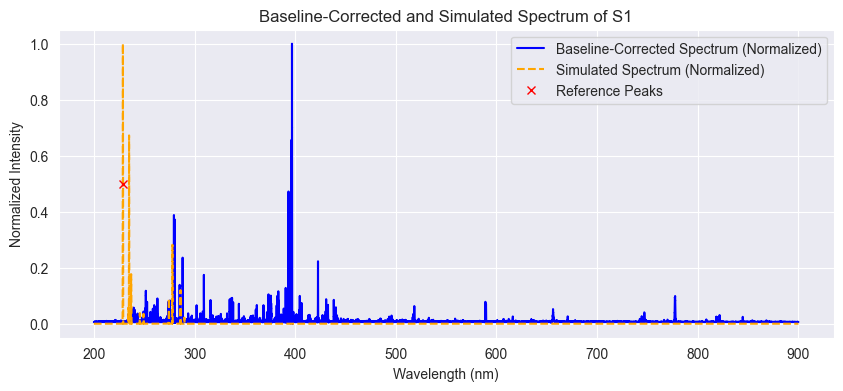

In [4]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tkinter import Tk, Button, Label, Entry, Frame, StringVar, OptionMenu, IntVar, DoubleVar, filedialog, ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy.signal import find_peaks

class DataFetcher:
    def __init__(self, db_nist, db_baseline_corrected):
        self.db_nist = db_nist
        self.db_baseline_corrected = db_baseline_corrected

    def get_nist_data(self, element, sp_num):
        conn = sqlite3.connect(self.db_nist)
        cursor = conn.cursor()
        query = """
            SELECT "obs_wl_air(nm)", "gA(s^-1)", "Ek(cm-1)", "Ei(cm-1)", "g_i", "g_k", "acc"
            FROM spectrum_data
            WHERE element = ? AND sp_num = ?
            AND "g_k" IS NOT NULL
            AND "gA(s^-1)" IS NOT NULL
            AND "Ek(cm-1)" IS NOT NULL
            AND "acc" IS NOT NULL
        """
        cursor.execute(query, (element, sp_num))
        data = cursor.fetchall()
        conn.close()
        return data

    def get_experimental_data(self, sample_name, iteration):
        conn = sqlite3.connect(self.db_baseline_corrected)
        cursor = conn.cursor()
        query = """
            SELECT wavelength, baseline_subtracted_signal
            FROM baseline_corrected_spectrum
            WHERE sample_name = ? AND iteration = ?
            ORDER BY wavelength
        """
        cursor.execute(query, (sample_name, iteration))
        data = cursor.fetchall()
        conn.close()

        if not data:
            print(f"No baseline-corrected data found for sample: {sample_name}, iteration: {iteration}")
            return np.array([]), np.array([])

        wavelengths, baseline_subtracted_intensities = zip(*data)
        return np.array(wavelengths, dtype=float), np.array(baseline_subtracted_intensities, dtype=float)

    def get_sample_names(self):
        conn = sqlite3.connect(self.db_baseline_corrected)
        cursor = conn.cursor()
        query = "SELECT DISTINCT sample_name FROM baseline_corrected_spectrum"
        cursor.execute(query)
        samples = [row[0] for row in cursor.fetchall()]
        conn.close()
        return samples

class ExcelDataLoader:
    def __init__(self):
        self.data = None

    def load_data(self, file_path):
        df = pd.read_excel(file_path)
        required_columns = ["Element", "Ion Stage", "NIST WL", "Einstein Coefficient"]
        if all(column in df.columns for column in required_columns):
            self.data = df
            print("Excel data loaded successfully.")
        else:
            print("Excel file is missing required columns.")

    def get_unique_elements(self):
        if self.data is not None:
            unique_elements = self.data[['Element', 'Ion Stage']].drop_duplicates()
            return unique_elements.values.tolist()
        return []

    def get_reference_peaks(self, element, ion_stage):
        if self.data is not None:
            return self.data[(self.data['Element'] == element) & (self.data['Ion Stage'] == ion_stage)][['NIST WL']]
        return pd.DataFrame(columns=['NIST WL'])

class SpectrumSimulator:
    def __init__(self, nist_data, temperature, resolution=24880):
        self.nist_data = nist_data
        self.temperature = temperature
        self.resolution = resolution

    @staticmethod
    def partition_function(energy_levels, degeneracies, T):
        k_B = 8.617333262145e-5
        Z = np.sum([g * np.exp(-E / (k_B * T)) for g, E in zip(degeneracies, energy_levels)])
        return Z

    @staticmethod
    def calculate_intensity(T, energy, degeneracy, einstein_coeff, Z):
        k_B = 8.617333262145e-5
        return (degeneracy * np.exp(-energy / (k_B * T)) * einstein_coeff) / Z

    @staticmethod
    def gaussian_profile(x, center, sigma):
        return np.exp(-0.5 * ((x - center) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))

    def simulate(self):
        wavelengths = np.linspace(200, 900, self.resolution)
        intensities = np.zeros_like(wavelengths)

        energy_levels = []
        degeneracies = []

        for wl, gA, Ek, Ei, gi, gk, acc in self.nist_data:
            if all(value is not None for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek, Ei = float(Ek), float(Ei)
                    Ei = Ei / 8065.544
                    gi = float(gi)
                    energy_levels.append(Ei)
                    degeneracies.append(gi)
                except ValueError:
                    continue

        Z = self.partition_function(energy_levels, degeneracies, self.temperature)

        for wl, gA, Ek, Ei, gi, gk, acc in self.nist_data:
            if all(value is not None for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek = float(Ek) / 8065.544
                    gi = float(gi)
                    gk = float(gk)
                    Aki = gA / gk
                    intensity = self.calculate_intensity(self.temperature, Ek, gk, Aki, Z)
                    sigma = 0.1
                    intensities += intensity * self.gaussian_profile(wavelengths, wl, sigma)
                except ValueError:
                    continue

        return wavelengths, intensities

class SpectrumPlotter:
    def __init__(self, main_frame):
        self.plot_frame = Frame(main_frame)
        self.plot_frame.pack(side="top", fill="both", expand=True)
        self.peak_frame = Frame(main_frame)
        self.peak_frame.pack(side="top", fill="both", expand=True)
        self.selected_sample = None

        save_button = Button(self.peak_frame, text="Save Selected to Excel", command=self.save_selected_to_excel)
        save_button.pack(pady=10)

    def plot_spectrum(self, wavelengths, intensities, sim_wavelengths, sim_intensities, ref_peaks):
        scaler = MinMaxScaler(feature_range=(0, 1))
        intensities_normalized = scaler.fit_transform(intensities.reshape(-1, 1)).flatten()
        sim_intensities_normalized = scaler.fit_transform(sim_intensities.reshape(-1, 1)).flatten()

        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(wavelengths, intensities_normalized, label='Baseline-Corrected Spectrum (Normalized)', color='blue')
        ax.plot(sim_wavelengths, sim_intensities_normalized, label='Simulated Spectrum (Normalized)', color='orange', linestyle='--')
        ax.plot(ref_peaks['NIST WL'], [0.5] * len(ref_peaks), "rx", label="Reference Peaks")
        ax.set_xlabel('Wavelength (nm)')
        ax.set_ylabel('Normalized Intensity')
        ax.set_title(f"Baseline-Corrected and Simulated Spectrum of {self.selected_sample}")
        ax.legend()
        ax.grid(True)

        for widget in self.plot_frame.winfo_children():
            widget.destroy()
        canvas = FigureCanvasTkAgg(fig, master=self.plot_frame)
        canvas.draw()
        canvas.get_tk_widget().pack()

    def display_filtered_peaks(self, matching_peaks):
        columns = ["Sim Peak WL", "NIST WL", "Element", "Ion Stage", "Einstein Coefficient", "Acc", "Exp Peak WL", "Exp Intensity"]

        if not hasattr(self, 'tree'):
            self.tree = ttk.Treeview(self.peak_frame, columns=columns, show='headings')
            for col in columns:
                self.tree.heading(col, text=col)
                self.tree.column(col, width=120)
            self.tree.pack()

        for row in self.tree.get_children():
            self.tree.delete(row)

        for peak in matching_peaks:
            self.tree.insert("", "end", values=[peak.get(col, "") for col in columns])

    def save_selected_to_excel(self):
        selected_items = self.tree.selection()
        data = []
        for item in selected_items:
            values = self.tree.item(item, "values")
            data.append(values)

        columns = ["Sim Peak WL", "NIST WL", "Element", "Ion Stage", "Einstein Coefficient", "Acc", "Exp Peak WL", "Exp Intensity"]
        df = pd.DataFrame(data, columns=columns)

        filename = f"{self.selected_sample}.xlsx"
        try:
            exist = pd.read_excel(filename)
            upd = pd.concat([exist, df], ignore_index=True)
        except FileNotFoundError:
            upd = df

        upd.to_excel(filename, index=False)
        print(f"Data saved to {filename}")

root = Tk()
root.title("Spectrum Analyzer with Baseline Correction Access")

main_frame = Frame(root)
main_frame.pack(side="right", padx=10, pady=10, fill="both", expand=True)

input_frame = Frame(root)
input_frame.pack(side="left", padx=10, pady=10)

sample_var = StringVar(root)
element_var = StringVar(root)
ion_stage_var = IntVar(value=1)
temperature_var = DoubleVar(value=11600)
iteration_var = IntVar(value=1)

Label(input_frame, text="Select Sample:").pack()
sample_menu = OptionMenu(input_frame, sample_var, "Select Sample")
sample_menu.pack()

Label(input_frame, text="Enter Iteration:").pack()
iteration_entry = Entry(input_frame, textvariable=iteration_var)
iteration_entry.pack()

Label(input_frame, text="Select Element and Ion Stage:").pack()
element_menu = OptionMenu(input_frame, element_var, "Select Element")
element_menu.pack()

Label(input_frame, text="Enter Temperature (K):").pack()
temperature_entry = Entry(input_frame, textvariable=temperature_var)
temperature_entry.pack()

data_fetcher = DataFetcher(db_nist='data1.db', db_baseline_corrected='processed_spectra.db')
spectrum_plotter = SpectrumPlotter(main_frame=main_frame)
data_loader = ExcelDataLoader()

def update_element_menu():
    elements = data_loader.get_unique_elements()
    element_menu["menu"].delete(0, "end")
    for element, ion_stage in elements:
        label = f"{element} {ion_stage}"
        element_menu["menu"].add_command(label=label, command=lambda el=label: element_var.set(el))
def load_excel_file():
    file_path = filedialog.askopenfilename(filetypes=[("Excel files", "*.xlsx")])
    if file_path:
        data_loader.load_data(file_path)
        update_element_menu()  # Pastikan menu elemen diperbarui setelah memuat data
def display_baseline_corrected_spectrum():
    spectrum_plotter.selected_sample = sample_var.get()
    sample_name = sample_var.get()
    iteration = iteration_var.get()

    # Cek apakah element_var diatur dengan benar
    element_ion_stage = element_var.get()
    if not element_ion_stage or len(element_ion_stage.split()) != 2:
        print("Error: Please select a valid element and ion stage (e.g., 'Fe 1').")
        return

    try:
        element, ion_stage = element_ion_stage.split()
        ion_stage = int(ion_stage)
    except ValueError:
        print("Error: Ion stage must be an integer.")
        return

    # Ambil data baseline-corrected sebagai data eksperimen
    wavelengths, intensities = data_fetcher.get_experimental_data(sample_name, iteration)
    if wavelengths.size == 0 or intensities.size == 0:
        print(f"No baseline-corrected data available for sample: {sample_name}, iteration: {iteration}")
        return

    # Simulasi spektrum berdasarkan data NIST
    nist_data = data_fetcher.get_nist_data(element, ion_stage)
    if len(nist_data) == 0:
        print(f"No NIST data available for element {element} and ion stage {ion_stage}.")
        return
    
    simulator = SpectrumSimulator(nist_data, temperature_var.get())
    sim_wavelengths, sim_intensities = simulator.simulate()

    # Ambil puncak referensi dari Excel
    ref_peaks = data_loader.get_reference_peaks(element, ion_stage)
    spectrum_plotter.plot_spectrum(wavelengths, intensities, sim_wavelengths, sim_intensities, ref_peaks)

    # Buat daftar puncak yang cocok untuk ditampilkan dalam tabel
    matching_peaks = [
        {
            "Sim Peak WL": sim_wl,
            "NIST WL": ref_wl[0],
            "Element": element,
            "Ion Stage": ion_stage,
            "Einstein Coefficient": nist[1],
            "Acc": nist[6],
            "Exp Peak WL": sim_wl,
            "Exp Intensity": np.max(sim_intensities)
        }
        for sim_wl, ref_wl, nist in zip(sim_wavelengths, ref_peaks.values, nist_data)
    ]
    spectrum_plotter.display_filtered_peaks(matching_peaks)
def update_sample_menu():
    samples = data_fetcher.get_sample_names()
    sample_menu["menu"].delete(0, "end")
    for sample in samples:
        sample_menu["menu"].add_command(label=sample, command=lambda s=sample: sample_var.set(s))
load_button = Button(input_frame, text="Load Excel Data", command=load_excel_file)
load_button.pack(pady=5)

simulate_button = Button(input_frame, text="Simulate and Display Spectrum", command=display_baseline_corrected_spectrum)
simulate_button.pack(pady=10)

update_sample_menu()
root.mainloop()

In [2]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tkinter import Tk, Button, Label, Entry, Frame, StringVar, OptionMenu, DoubleVar, IntVar, filedialog, ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from scipy.signal import find_peaks

class DataFetcher:
    def __init__(self, db_nist, db_spectrum):
        self.db_nist = db_nist
        self.db_spectrum = db_spectrum

    def get_nist_data(self, element, sp_num):
        conn = sqlite3.connect(self.db_nist)
        cursor = conn.cursor()
        query = """
            SELECT "obs_wl_air(nm)", "gA(s^-1)", "Ek(cm-1)", "Ei(cm-1)", "g_i", "g_k", "acc"
            FROM spectrum_data
            WHERE element = ? AND sp_num = ?
            AND "g_k" IS NOT NULL
            AND "gA(s^-1)" IS NOT NULL
            AND "Ek(cm-1)" IS NOT NULL
            AND "acc" IS NOT NULL
        """
        cursor.execute(query, (element, sp_num))
        data = cursor.fetchall()
        conn.close()
        return data

    def get_experimental_data(self, sample_name):
        conn = sqlite3.connect(self.db_spectrum)
        cursor = conn.cursor()
        query = """
            SELECT wavelength, intensity
            FROM processed_spectrum
            WHERE sample_name = ? AND wavelength BETWEEN 200 AND 900
            ORDER BY wavelength
        """
        cursor.execute(query, (sample_name,))
        data = cursor.fetchall()
        conn.close()

        if not data:
            print(f"No data found for sample: {sample_name}")
            return np.array([]), np.array([])

        wavelengths, intensities = zip(*data)
        return np.array(wavelengths, dtype=float), np.array(intensities, dtype=float)

    def get_sample_names(self):
        conn = sqlite3.connect(self.db_spectrum)
        cursor = conn.cursor()
        query = "SELECT DISTINCT sample_name FROM processed_spectrum"
        cursor.execute(query)
        samples = [row[0] for row in cursor.fetchall()]
        conn.close()
        return samples

class ExcelDataLoader:
    def __init__(self):
        self.data = None

    def load_data(self, file_path):
        df = pd.read_excel(file_path)
        required_columns = ["Element", "Ion Stage", "NIST WL", "Einstein Coefficient"]
        if all(column in df.columns for column in required_columns):
            self.data = df
            print("Excel data loaded successfully.")
        else:
            print("Excel file is missing required columns.")

    def get_unique_elements(self):
        if self.data is not None:
            unique_elements = self.data[['Element', 'Ion Stage']].drop_duplicates()
            return unique_elements.values.tolist()
        return []

    def get_reference_peaks(self, element, ion_stage):
        if self.data is not None:
            return self.data[(self.data['Element'] == element) & (self.data['Ion Stage'] == ion_stage)][['NIST WL']]
        return pd.DataFrame(columns=['NIST WL'])

class SpectrumSimulator:
    def __init__(self, nist_data, temperature, resolution=24880):
        self.nist_data = nist_data
        self.temperature = temperature
        self.resolution = resolution

    @staticmethod
    def partition_function(energy_levels, degeneracies, T):
        k_B = 8.617333262145e-5
        Z = np.sum([g * np.exp(-E / (k_B * T)) for g, E in zip(degeneracies, energy_levels)])
        return Z

    @staticmethod
    def calculate_intensity(T, energy, degeneracy, einstein_coeff, Z):
        k_B = 8.617333262145e-5
        return (degeneracy * np.exp(-energy / (k_B * T)) * einstein_coeff) / Z

    @staticmethod
    def gaussian_profile(x, center, sigma):
        return np.exp(-0.5 * ((x - center) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))

    def simulate(self):
        wavelengths = np.linspace(200, 900, self.resolution)
        intensities = np.zeros_like(wavelengths)

        energy_levels = []
        degeneracies = []

        for wl, gA, Ek, Ei, gi, gk, acc in self.nist_data:
            if all(value is not None for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek, Ei = float(Ek), float(Ei)
                    Ei = Ei / 8065.544
                    gi = float(gi)
                    energy_levels.append(Ei)
                    degeneracies.append(gi)
                except ValueError:
                    continue

        Z = self.partition_function(energy_levels, degeneracies, self.temperature)

        for wl, gA, Ek, Ei, gi, gk, acc in self.nist_data:
            if all(value is not None for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek = float(Ek) / 8065.544
                    gi = float(gi)
                    gk = float(gk)
                    Aki = gA / gk
                    intensity = self.calculate_intensity(self.temperature, Ek, gk, Aki, Z)
                    sigma = 0.1
                    intensities += intensity * self.gaussian_profile(wavelengths, wl, sigma)
                except ValueError:
                    continue

        return wavelengths, intensities

class SpectrumPlotter:
    def __init__(self, main_frame):
        self.plot_frame = Frame(main_frame)
        self.plot_frame.pack(side="top", fill="both", expand=True)
        self.peak_frame = Frame(main_frame)
        self.peak_frame.pack(side="top", fill="both", expand=True)
        self.selected_sample = None

        save_button = Button(self.peak_frame, text="Save Selected to Excel", command=self.save_selected_to_excel)
        save_button.pack(pady=10)

    def plot_spectrum(self, exp_wavelengths, exp_intensities, sim_wavelengths, sim_intensities, ref_peaks):
        scaler = MinMaxScaler(feature_range=(0, 1))
        exp_intensities_normalized = scaler.fit_transform(exp_intensities.reshape(-1, 1)).flatten()
        sim_intensities_normalized = scaler.fit_transform(sim_intensities.reshape(-1, 1)).flatten()

        lower_bound = lower_bound_var.get()
        upper_bound = upper_bound_var.get()
        ref_peaks_filtered = ref_peaks[(ref_peaks['NIST WL'] >= lower_bound) & (ref_peaks['NIST WL'] <= upper_bound)]

        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(exp_wavelengths, exp_intensities_normalized, label='Experimental Spectrum (Normalized)', color='blue')
        ax.plot(sim_wavelengths, sim_intensities_normalized, label='Simulated Spectrum (Normalized)', color='orange', linestyle='--')
        ax.plot(ref_peaks_filtered['NIST WL'], [0.5] * len(ref_peaks_filtered), "rx", label="Reference Peaks")
        ax.set_xlabel('Wavelength (nm)')
        ax.set_ylabel('Normalized Intensity')
        ax.set_title("Experimental and Simulated Spectrum with Filtered Reference Peaks")
        ax.grid(True)
        ax.legend()

        for widget in self.plot_frame.winfo_children():
            widget.destroy()
        canvas = FigureCanvasTkAgg(fig, master=self.plot_frame)
        canvas.draw()
        canvas.get_tk_widget().pack()

    def display_filtered_peaks(self, matching_peaks):
        columns = ["Sim Peak WL", "NIST WL", "Element", "Ion Stage", "Einstein Coefficient", "Acc", "Exp Peak WL", "Exp Intensity"]

        if not hasattr(self, 'tree'):
            self.tree = ttk.Treeview(self.peak_frame, columns=columns, show='headings')
            for col in columns:
                self.tree.heading(col, text=col)
                self.tree.column(col, width=120)
            self.tree.pack()

        for row in self.tree.get_children():
            self.tree.delete(row)

        for peak in matching_peaks:
            self.tree.insert("", "end", values=[peak.get(col, "") for col in columns])

    def save_selected_to_excel(self):
        selected_items = self.tree.selection()
        data = []
        for item in selected_items:
            values = self.tree.item(item, "values")
            data.append(values)

        columns = ["Sim Peak WL", "NIST WL", "Element", "Ion Stage", "Einstein Coefficient", "Acc", "Exp Peak WL", "Exp Intensity"]
        df = pd.DataFrame(data, columns=columns)

        filename = f"{self.selected_sample}.xlsx"
        try:
            exist = pd.read_excel(filename)
            upd = pd.concat([exist, df], ignore_index=True)
        except FileNotFoundError:
            upd = df

        upd.to_excel(filename, index=False)
        print(f"Data saved to {filename}")

root = Tk()
root.title("Filtered Spectrum Analyzer with Adjustable Parameters")

main_frame = Frame(root)
main_frame.pack(side="right", padx=10, pady=10, fill="both", expand=True)

input_frame = Frame(root)
input_frame.pack(side="left", padx=10, pady=10)

sample_var = StringVar(root)
element_var = StringVar(root)
ion_stage_var = IntVar(value=1)
temperature_var = DoubleVar(value=11600)
lower_bound_var = DoubleVar(value=200)
upper_bound_var = DoubleVar(value=900)

Label(input_frame, text="Select Sample:").pack()
sample_menu = OptionMenu(input_frame, sample_var, "Select Sample")
sample_menu.pack()

Label(input_frame, text="Select Element and Ion Stage:").pack()
element_menu = OptionMenu(input_frame, element_var, "Select Element")
element_menu.pack()

Label(input_frame, text="Enter Temperature (K):").pack()
temperature_entry = Entry(input_frame, textvariable=temperature_var)
temperature_entry.pack()

Label(input_frame, text="Lower Bound (nm):").pack()
lower_bound_entry = Entry(input_frame, textvariable=lower_bound_var)
lower_bound_entry.pack()

Label(input_frame, text="Upper Bound (nm):").pack()
upper_bound_entry = Entry(input_frame, textvariable=upper_bound_var)
upper_bound_entry.pack()

def simulate_and_display():
    spectrum_plotter.selected_sample = sample_var.get()
    sample_name = sample_var.get()
    element, ion_stage = element_var.get().split()
    ion_stage = int(ion_stage)
    temperature = temperature_var.get()
    lower_bound = lower_bound_var.get()
    upper_bound = upper_bound_var.get()

    nist_data = data_fetcher.get_nist_data(element, ion_stage)
    exp_wavelengths, exp_intensities = data_fetcher.get_experimental_data(sample_name)
    if exp_wavelengths.size == 0 or exp_intensities.size == 0:
        print(f"No data found for sample: {sample_name}")
        return

    simulator = SpectrumSimulator(nist_data, temperature)
    sim_wavelengths, sim_intensities = simulator.simulate()

    ref_peaks = data_loader.get_reference_peaks(element, ion_stage)
    ref_peaks_filtered = ref_peaks[(ref_peaks['NIST WL'] >= lower_bound) & (ref_peaks['NIST WL'] <= upper_bound)]

    exp_peaks_idx, _ = find_peaks(exp_intensities, height=0.0001, distance=10)
    exp_peaks_wavelengths = exp_wavelengths[exp_peaks_idx]
    exp_peaks_intensities = exp_intensities[exp_peaks_idx]

    exp_mask = (exp_wavelengths >= lower_bound) & (exp_wavelengths <= upper_bound)
    sim_mask = (sim_wavelengths >= lower_bound) & (sim_wavelengths <= upper_bound)
    exp_wavelengths_filtered = exp_wavelengths[exp_mask]
    exp_intensities_filtered = exp_intensities[exp_mask]
    sim_wavelengths_filtered = sim_wavelengths[sim_mask]
    sim_intensities_filtered = sim_intensities[sim_mask]

    matching_peaks = []
    tolerance = 0.5
    for ref_wl in ref_peaks_filtered['NIST WL']:
        ref_wl = float(ref_wl)

        nearest_peak_idx = np.argmin(np.abs(exp_peaks_wavelengths - ref_wl))
        nearest_wl = exp_peaks_wavelengths[nearest_peak_idx]
        nearest_intensity = exp_peaks_intensities[nearest_peak_idx]

        nist_entry = next((entry for entry in nist_data if abs(float(entry[0]) - ref_wl) <= tolerance), None)
        
        if nist_entry and abs(nearest_wl - ref_wl) <= tolerance:
            matching_peaks.append({
                "Sim Peak WL": nearest_wl,
                "NIST WL": ref_wl,
                "Element": element,
                "Ion Stage": ion_stage,
                "Einstein Coefficient": nist_entry[1],
                "Acc": nist_entry[6],
                "Exp Peak WL": nearest_wl,
                "Exp Intensity": nearest_intensity
            })

    spectrum_plotter.plot_spectrum(exp_wavelengths_filtered, exp_intensities_filtered, sim_wavelengths_filtered, sim_intensities_filtered, ref_peaks_filtered)
    spectrum_plotter.display_filtered_peaks(matching_peaks)

def load_excel_file():
    file_path = filedialog.askopenfilename(filetypes=[("Excel files", "*.xlsx")])
    if file_path:
        data_loader.load_data(file_path)
        update_element_menu()

def update_element_menu():
    elements = data_loader.get_unique_elements()
    element_menu["menu"].delete(0, "end")
    for element, ion_stage in elements:
        label = f"{element} {ion_stage}"
        element_menu["menu"].add_command(label=label, command=lambda el=label: element_var.set(el))

def update_sample_menu():
    samples = data_fetcher.get_sample_names()
    sample_menu["menu"].delete(0, "end")
    for sample in samples:
        sample_menu["menu"].add_command(label=sample, command=lambda s=sample: sample_var.set(s))

analyze_button = Button(input_frame, text="Analyze Segment", command=simulate_and_display)
analyze_button.pack(pady=10)

data_loader = ExcelDataLoader()
data_fetcher = DataFetcher(db_nist='data1.db', db_spectrum='processed_spectra.db')
spectrum_plotter = SpectrumPlotter(main_frame=main_frame)

load_button = Button(input_frame, text="Load Excel Data", command=load_excel_file)
load_button.pack(pady=5)

update_sample_menu()

root.mainloop()

In [ ]:
j = 14*60*3*10**8
print(j)

2024-12-06 20:55:36.244 Python[19671:747993] +[IMKClient subclass]: chose IMKClient_Modern
2024-12-06 20:55:36.244 Python[19671:747993] +[IMKInputSession subclass]: chose IMKInputSession_Modern
/var/folders/6h/9dyt7k995lxfs8jyls0_pss80000gn/T/ipykernel_19671/504236777.py:323: RuntimeWarning: invalid value encountered in divide
  sim_intensities = sim_intensities[atomic_mask] / np.max(sim_intensities)


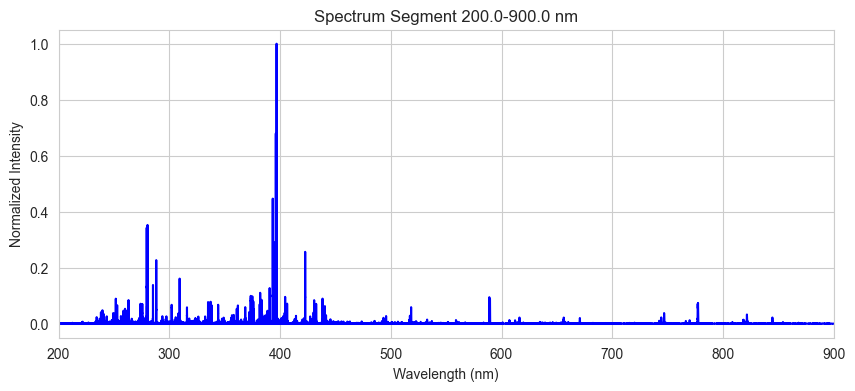

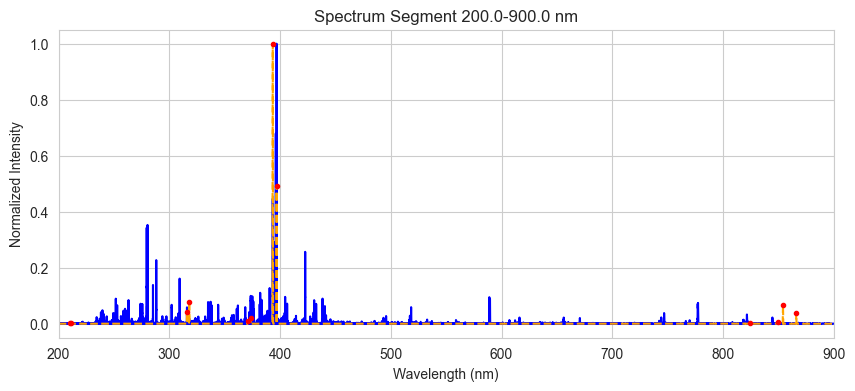

In [1]:
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from tkinter import Tk, Button, Label, Entry, Frame, StringVar, OptionMenu, ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
from adjustText import adjust_text

# Class to handle data fetching from databases
class DataFetcher:
    def __init__(self, db_nist, db_spectrum):
        self.db_nist = db_nist
        self.db_spectrum = db_spectrum

    def get_nist_data(self, element, sp_num):
        conn = sqlite3.connect(self.db_nist)
        cursor = conn.cursor()
        query = """
            SELECT "obs_wl_air(nm)", "gA(s^-1)", "Ek(cm-1)", "Ei(cm-1)", "g_i", "g_k", "acc"
            FROM spectrum_data
            WHERE element = ? AND sp_num = ?
        """
        cursor.execute(query, (element, sp_num))
        data = cursor.fetchall()
        conn.close()
        return data

    def get_experimental_data(self, sample_name):
        conn = sqlite3.connect(self.db_spectrum)
        cursor = conn.cursor()
        query = """
            SELECT wavelength, intensity
            FROM processed_spectrum
            WHERE sample_name = ?  AND wavelength BETWEEN 200 AND 900
            ORDER BY wavelength
        """
        cursor.execute(query, (sample_name,))
        data = cursor.fetchall()
        conn.close()

        if not data:
            print(f"No data found for sample: {sample_name}")
            return np.array([]), np.array([])

        wavelengths, intensities = zip(*data)
        return np.array(wavelengths, dtype=float), np.array(intensities, dtype=float)

# Class to handle atomic spectrum simulation
class SpectrumSimulator:
    def __init__(self, nist_data, temperature, resolution=24880):
        self.nist_data = nist_data
        self.temperature = temperature
        self.resolution = resolution

    @staticmethod
    def partition_function(energy_levels, degeneracies, T):
        k_B = 8.617333262145e-5
        Z = np.sum([g * np.exp(-E / (k_B * T)) for g, E in zip(degeneracies, energy_levels)])
        return Z

    @staticmethod
    def calculate_intensity(T, energy, degeneracy, einstein_coeff, Z):
        k_B = 8.617333262145e-5
        return (degeneracy * np.exp(-energy / (k_B * T)) * einstein_coeff) / Z

    @staticmethod
    def gaussian_profile(x, center, sigma):
        return np.exp(-0.5 * ((x - center) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))

    def simulate(self):
        wavelengths = np.linspace(200, 900, self.resolution)
        intensities = np.zeros_like(wavelengths)

        energy_levels = []
        degeneracies = []

        for wl, gA, Ek, Ei, gi, gk, acc in self.nist_data:
            if all(value is not None for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek, Ei = float(Ek), float(Ei)
                    Ei = Ei / 8065.544
                    gi = float(gi)
                    energy_levels.append(Ei)
                    degeneracies.append(gi)
                except ValueError:
                    continue

        Z = self.partition_function(energy_levels, degeneracies, self.temperature)

        for wl, gA, Ek, Ei, gi, gk, acc in self.nist_data:
            if all(value is not None for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek = float(Ek) / 8065.544
                    gi = float(gi)
                    gk = float(gk)
                    Aki = gA / gk
                    intensity = self.calculate_intensity(self.temperature, Ek, gk, Aki, Z)
                    sigma = 0.1
                    intensities += intensity * self.gaussian_profile(wavelengths, wl, sigma)
                except ValueError:
                    continue

        return wavelengths, intensities

# Class to handle plotting of experimental and atomic spectra
class SpectrumPlotter:
    def __init__(self, main_frame):
        self.plot_frame = Frame(main_frame)
        self.plot_frame.pack(side="top", fill="both", expand=True)

        self.peak_frame = Frame(main_frame)
        self.peak_frame.pack(side="top", fill="both", expand=True)

        self.selected_sample = ""
        self.tree = None

    def find_experimental_peaks(self, exp_wavelengths, exp_intensities):
        peaks, _ = find_peaks(exp_intensities, height=0.0001, distance=10)
        return exp_wavelengths[peaks], exp_intensities[peaks]

    def find_matching_peaks(self, sim_wavelengths, sim_peaks, exp_peaks_wl, exp_peaks_intensity, nist_data, element, sp_num):
        matches = []
        tolerance = 0.5
        for peak_idx in sim_peaks:
            sim_peak_wl = sim_wavelengths[peak_idx]
            for i, exp_wl in enumerate(exp_peaks_wl):
                if abs(sim_peak_wl - exp_wl) <= tolerance:
                    closest_exp_intensity = exp_peaks_intensity[i]
                    for nist_wl, gA, Ek, Ei, gi, gk, acc in nist_data:
                        if gk is None or Ek is None or gA is None or acc is None:
                            continue  
                        try:
                            nist_wl = float(nist_wl)
                            if abs(sim_peak_wl - nist_wl) <= tolerance:
                                matches.append({
                                    "Sim Peak WL": sim_peak_wl,
                                    "NIST WL": nist_wl,
                                    "Element": element,
                                    "Ion Stage": sp_num,
                                    "Einstein Coefficient": gA,
                                    "Acc": acc,
                                    "Exp Peak WL": exp_wl,
                                    "Exp Intensity": closest_exp_intensity
                                })
                        except ValueError:
                            continue
        return matches

    def display_peak_table(self, matching_peaks):
        # Sort the peaks by 'Exp Intensity' in descending order
        sorted_peaks = sorted(matching_peaks, key=lambda x: x.get("Exp Intensity", 0), reverse=True)
        
        # Clear previous table
        for widget in self.peak_frame.winfo_children():
            widget.destroy()
    
        # Define table columns
        columns = ["Sim Peak WL", "NIST WL", "Element", "Ion Stage", "Einstein Coefficient", "Acc", "Exp Peak WL", "Exp Intensity"]
        tree = ttk.Treeview(self.peak_frame, columns=columns, show='headings', selectmode="extended")
    
        # Set up columns
        for col in columns:
            tree.heading(col, text=col)
            tree.column(col, width=120)
    
        # Insert matching peaks data with sorted experimental peaks
        for peak in sorted_peaks:
            tree.insert("", "end", values=[peak.get(col, "") for col in columns])
    
        tree.pack()
        self.tree = tree  # Reference for exporting data
    
        # Add the Save to Excel button below the table
        save_button = Button(self.peak_frame, text="Save Selected to Excel", command=self.save_selected_to_excel)
        save_button.pack(pady=10)
        save_button.bind("<Return>", lambda event: self.save_selected_to_excel())
    def save_selected_to_excel(self):
        selected_items = self.tree.selection()
        data = []
        for item in selected_items:
            values = self.tree.item(item, "values")
            data.append(values)

        columns = ["Sim Peak WL", "NIST WL", "Element", "Ion Stage", "Einstein Coefficient", "Acc", "Exp Peak WL", "Exp Intensity"]
        df = pd.DataFrame(data, columns=columns)

        filename = f"{self.selected_sample}.xlsx"
        try:
            exist = pd.read_excel(filename)
            upd = pd.concat([exist, df])
        except FileNotFoundError:
            upd = df

        upd.to_excel(filename, index=False)
        print(f"Data saved to {filename}")

    def load_excel_data(self, filename):
        try:
            df = pd.read_excel(filename)
            print("Loaded columns from Excel:", df.columns)
            return df
        except FileNotFoundError:
            print(f"File '{filename}' not found.")
            return None

    import plotly.graph_objects as go
    import plotly.express as px

    def plot_with_labels(self):
        # Load data from the saved Excel file for the selected sample
        filename = f"{self.selected_sample}.xlsx"
        try:
            df = pd.read_excel(filename)
        except FileNotFoundError:
            print(f"No saved data found for sample {self.selected_sample}.")
            return

        exp_peak_wls = sorted(df['Exp Peak WL'].dropna().unique())
        total_range = max(exp_peak_wls) - min(exp_peak_wls)
        num_pages = 4  # Total number of pages

        # Define the segments based on the total range and number of pages
        segments = []
        for i in range(num_pages):
            lower = min(exp_peak_wls) + (total_range / num_pages) * i
            upper = lower + (total_range / num_pages)
            segments.append((lower, upper))

        for lower, upper in segments:
            # Create a new figure
            fig = go.Figure()

            # Experimental data
            mask = (self.exp_wavelengths >= lower) & (self.exp_wavelengths <= upper)
            wl_segment = self.exp_wavelengths[mask]
            intensity_segment = self.exp_intensities[mask]

            if len(wl_segment) == 0 or len(intensity_segment) == 0:
                print(f"No data in range {lower} - {upper}")
                continue  # Move to the next segment

            fig.add_trace(go.Scatter(x=wl_segment, y=intensity_segment, mode='lines', name='Experimental Data (Sample)', line=dict(color='blue')))

            # Get peaks in the current segment
            segment_df = df[(df['Exp Peak WL'] >= lower) & (df['Exp Peak WL'] <= upper)].copy()
            if segment_df.empty:
                continue  # Move to the next segment

            # Filter peaks with intensity greater than 0.1
            segment_df = segment_df[segment_df['Exp Intensity'] > 0.1]

            # Group by Element and Ion Stage
            grouped = segment_df.groupby(['Element', 'Ion Stage'])

            # Create annotations for each peak
            for (element, ion_stage), group in grouped:
                # Sort the group by intensity and select the top peaks
                top_peaks = group.nlargest(10, 'Exp Intensity')

                for _, peak in top_peaks.iterrows():
                    exp_peak_wl = peak['Exp Peak WL']
                    exp_intensity = peak['Exp Intensity']
                    ion_stage_label = {1: "I", 2: "II", 3: "III", 4: "IV", 5: "V"}.get(ion_stage, str(ion_stage))
                    label_key = f"{element} {ion_stage_label}"

                    # Position the label above the peak
                    label_y_position = exp_intensity + 0.02 * max(intensity_segment)  # Adjust vertical offset

                    # Add the label with an arrow pointing up to the peak
                    fig.add_annotation(
                        x=exp_peak_wl,
                        y=label_y_position,
                        text=label_key,
                        showarrow=True,
                        arrowhead=2,
                        ax=0,
                        ay=-40,  # Adjust this value to position the arrow
                        font=dict(size=10),
                        bgcolor="white",
                        bordercolor="black",
                        borderwidth=1,
                        borderpad=4,
                        opacity=0.8
                    )

            # Update layout
            fig.update_layout(
                title=f"Spectrum Segment {lower:.1f}-{upper:.1f} nm",
                xaxis_title='Wavelength (nm)',
                yaxis_title='Intensity',
                yaxis=dict(range=[0, 1.2 * max(intensity_segment)]),  # Adjust y-axis range
                showlegend=True
            )

            # Show the figure
            fig.show()




    def plot(self, exp_wavelengths, exp_intensities, sim_wavelengths, sim_intensities, nist_data, element, sp_num, sample_name, lower, upper, intensity_lower, intensity_upper):
        self.selected_sample = sample_name
        self.exp_wavelengths = exp_wavelengths
        self.exp_intensities = exp_intensities

        fig, ax = plt.subplots(figsize=(10, 4))
        ax.set_xlim(lower, upper)
        ax.set_title(f"Spectrum Segment {lower}-{upper} nm")

        mask = (exp_wavelengths >= lower) & (exp_wavelengths < upper)
        wl_segment = exp_wavelengths[mask]
        intensity_segment = exp_intensities[mask] / np.max(exp_intensities[mask])
        ax.plot(wl_segment, intensity_segment, label='Experimental Data (Sample)', color='blue')

        atomic_mask = (sim_wavelengths >= lower) & (sim_wavelengths < upper)
        sim_wavelengths = sim_wavelengths[atomic_mask]
        sim_intensities = sim_intensities[atomic_mask] / np.max(sim_intensities)
        ax.plot(sim_wavelengths, sim_intensities, label='Simulated Atomic Spectrum', color='orange', linestyle='--')

        sim_peaks, _ = find_peaks(sim_intensities, height=0.001)
        ax.plot(sim_wavelengths[sim_peaks], sim_intensities[sim_peaks], "r.", label="Simulated Peaks")

        ax.set_xlabel('Wavelength (nm)')
        ax.set_ylabel('Normalized Intensity')
        ax.grid(True)
        #ax.legend(loc="upper right")

        for widget in self.plot_frame.winfo_children():
            widget.destroy()
        canvas = FigureCanvasTkAgg(fig, master=self.plot_frame)
        canvas.draw()
        canvas.get_tk_widget().pack()

        exp_peaks_wl, exp_peaks_intensity = self.find_experimental_peaks(exp_wavelengths, exp_intensities)
        matching_peaks = self.find_matching_peaks(sim_wavelengths, sim_peaks, exp_peaks_wl, exp_peaks_intensity, nist_data, element, sp_num)
        self.display_peak_table(matching_peaks)

# GUI setup and event handling
root = Tk()
root.title("Spectrum Analyzer")

main_frame = Frame(root)
main_frame.pack(side="right", padx=10, pady=10, fill="both", expand=True)

data_fetcher = DataFetcher(db_nist='data1.db', db_spectrum='processed_spectra.db')
spectrum_plotter = SpectrumPlotter(main_frame=main_frame)

input_frame = Frame(root)
input_frame.pack(side="left", padx=10, pady=10)

Label(input_frame, text="Enter Element:").pack()
element_entry = Entry(input_frame)
element_entry.pack()

Label(input_frame, text="Select Ion Stage:").pack()
ion_stage_var = StringVar(root)
ion_stage_var.set("1")
ion_stage_menu = OptionMenu(input_frame, ion_stage_var, "1", "2", "3", "4", "5")
ion_stage_menu.pack()

Label(input_frame, text="Enter Temperature (K):").pack()
temperature_entry = Entry(input_frame)
temperature_entry.insert(0, "11600")
temperature_entry.pack()

Label(input_frame, text="Lower Bound (nm):").pack()
lower_bound_entry = Entry(input_frame)
lower_bound_entry.insert(0, "200")
lower_bound_entry.pack()

Label(input_frame, text="Upper Bound (nm):").pack()
upper_bound_entry = Entry(input_frame)
upper_bound_entry.insert(0, "900")
upper_bound_entry.pack()

Label(input_frame, text="Intensity Lower Bound:").pack()
intensity_lower_entry = Entry(input_frame)
intensity_lower_entry.insert(0, "0.001")
intensity_lower_entry.pack()

Label(input_frame, text="Intensity Upper Bound:").pack()
intensity_upper_entry = Entry(input_frame)
intensity_upper_entry.insert(0, "1.0")
intensity_upper_entry.pack()

Label(input_frame, text="Select Sample:").pack()
sample_var = StringVar(root)
sample_var.set("S1")
sample_menu = OptionMenu(input_frame, sample_var, *[f"S{i}" for i in range(1, 25)])
sample_menu.pack()

def on_analyze():
    element = element_entry.get().strip()
    sp_num = int(ion_stage_var.get())
    temperature = float(temperature_entry.get())
    lower = float(lower_bound_entry.get())
    upper = float(upper_bound_entry.get())
    intensity_lower = float(intensity_lower_entry.get())
    intensity_upper = float(intensity_upper_entry.get())
    sample_name = sample_var.get()

    exp_wavelengths, exp_intensities = data_fetcher.get_experimental_data(sample_name)
    nist_data = data_fetcher.get_nist_data(element, sp_num)

    simulator = SpectrumSimulator(nist_data, temperature)
    sim_wavelengths, sim_intensities = simulator.simulate()

    spectrum_plotter.plot(exp_wavelengths, exp_intensities, sim_wavelengths, sim_intensities, nist_data, element,
                          sp_num, sample_name, lower, upper, intensity_lower, intensity_upper)

analyze_button = Button(input_frame, text="Analyze Segment", command=on_analyze)
analyze_button.pack(pady=10)

plot_labels_button = Button(input_frame, text="Plot Labeled Spectrum", command=spectrum_plotter.plot_with_labels)
plot_labels_button.pack(pady=10)

root.mainloop()

In [ ]:
import numpy as np
import sqlite3
import pandas as pd
from scipy.signal import find_peaks
from tkinter import Tk, Button, Label, Entry, Frame, StringVar, OptionMenu, ttk
import plotly.graph_objects as go

# Class to handle data fetching from databases
class DataFetcher:
    def __init__(self, db_nist, db_spectrum):
        self.db_nist = db_nist
        self.db_spectrum = db_spectrum

    def get_nist_data(self, element, sp_num):
        conn = sqlite3.connect(self.db_nist)
        cursor = conn.cursor()
        query = """
            SELECT "obs_wl_air(nm)", "gA(s^-1)", "Ek(cm-1)", "Ei(cm-1)", "g_i", "g_k", "acc"
            FROM spectrum_data
            WHERE element = ? AND sp_num = ?
        """
        cursor.execute(query, (element, sp_num))
        data = cursor.fetchall()
        conn.close()
        return data

    def get_experimental_data(self, sample_name):
        conn = sqlite3.connect(self.db_spectrum)
        cursor = conn.cursor()
        query = """
            SELECT wavelength, intensity
            FROM processed_spectrum
            WHERE sample_name = ?  AND wavelength BETWEEN 200 AND 900
            ORDER BY wavelength
        """
        cursor.execute(query, (sample_name,))
        data = cursor.fetchall()
        conn.close()

        if not data:
            print(f"No data found for sample: {sample_name}")
            return np.array([]), np.array([])

        wavelengths, intensities = zip(*data)
        return np.array(wavelengths, dtype=float), np.array(intensities, dtype=float)

# Class to handle plotting of experimental spectra
class SpectrumPlotter:
    def __init__(self, main_frame):
        self.plot_frame = Frame(main_frame)
        self.plot_frame.pack(side="top", fill="both", expand=True)

        self.selected_sample = ""

    def plot_with_labels(self, exp_wavelengths, exp_intensities):
        # Find peaks in the experimental data
        peaks, _ = find_peaks(exp_intensities, height=0.1, distance=10)
        peak_wavelengths = exp_wavelengths[peaks]
        peak_intensities = exp_intensities[peaks]

        # Create a new figure
        fig = go.Figure()

        # Add experimental data
        fig.add_trace(go.Scatter(x=exp_wavelengths, y=exp_intensities, mode='lines', name='Experimental Data', line=dict(color='blue')))

        # Add peaks with labels
        for wl, intensity in zip(peak_wavelengths, peak_intensities):
            fig.add_trace(go.Scatter(
                x=[wl],
                y=[intensity],
                mode='markers+text',
                marker=dict(color='red', size=10),
                text=[f"Wavelength: {wl:.2f} nm<br>Intensity: {intensity:.2f}"],
                textposition="top center",
                name='Peaks'
            ))

        # Update layout
        fig.update_layout(
            title='Spectrum with Labeled Peaks',
            xaxis_title='Wavelength (nm)',
            yaxis_title='Intensity',
            showlegend=True
        )

        # Show the figure
        fig.show()

# GUI setup and event handling
root = Tk()
root.title("Spectrum Analyzer")

main_frame = Frame(root)
main_frame.pack(side="right", padx=10, pady=10, fill="both", expand=True)

data_fetcher = DataFetcher(db_nist='data1.db', db_spectrum='processed_spectra.db')
spectrum_plotter = SpectrumPlotter(main_frame=main_frame)

input_frame = Frame(root)
input_frame.pack(side="left", padx=10, pady=10)

Label(input_frame, text="Enter Sample Name:").pack()
sample_entry = Entry(input_frame)
sample_entry.pack()

def on_plot():
    sample_name = sample_entry.get().strip()
    exp_wavelengths, exp_intensities = data_fetcher.get_experimental_data(sample_name)
    if exp_wavelengths.size == 0:
        print("No experimental data found.")
        return
    spectrum_plotter.plot_with_labels(exp_wavelengths, exp_intensities)

plot_button = Button(input_frame, text="Plot Spectrum with Labels", command=on_plot)
plot_button.pack(pady=10)

root.mainloop()


In [27]:
import numpy as np
import sqlite3
import pandas as pd
from scipy.signal import find_peaks
from tkinter import Tk, Button, Label, Entry, Frame, StringVar, OptionMenu, ttk
import plotly.graph_objects as go

# Class to handle data fetching from databases
class DataFetcher:
    def __init__(self, db_nist, db_spectrum):
        self.db_nist = db_nist
        self.db_spectrum = db_spectrum

    def get_nist_data(self, element, sp_num):
        conn = sqlite3.connect(self.db_nist)
        cursor = conn.cursor()
        query = """
            SELECT "obs_wl_air(nm)", "gA(s^-1)", "Ek(cm-1)", "Ei(cm-1)", "g_i", "g_k", "acc"
            FROM spectrum_data
            WHERE element = ? AND sp_num = ?
        """
        cursor.execute(query, (element, sp_num))
        data = cursor.fetchall()
        conn.close()
        return data

    def get_experimental_data(self, sample_name):
        conn = sqlite3.connect(self.db_spectrum)
        cursor = conn.cursor()
        query = """
            SELECT wavelength, intensity
            FROM processed_spectrum
            WHERE sample_name = ?  AND wavelength BETWEEN 200 AND 900
            ORDER BY wavelength
        """
        cursor.execute(query, (sample_name,))
        data = cursor.fetchall()
        conn.close()

        if not data:
            print(f"No data found for sample: {sample_name}")
            return np.array([]), np.array([])

        wavelengths, intensities = zip(*data)
        return np.array(wavelengths, dtype=float), np.array(intensities, dtype=float)

# Class to handle atomic spectrum simulation
class SpectrumSimulator:
    def __init__(self, nist_data, temperature, resolution=24880):
        self.nist_data = nist_data
        self.temperature = temperature
        self.resolution = resolution

    @staticmethod
    def partition_function(energy_levels, degeneracies, T):
        k_B = 8.617333262145e-5
        Z = np.sum([g * np.exp(-E / (k_B * T)) for g, E in zip(degeneracies, energy_levels)])
        return Z

    @staticmethod
    def calculate_intensity(T, energy, degeneracy, einstein_coeff, Z):
        k_B = 8.617333262145e-5
        return (degeneracy * np.exp(-energy / (k_B * T)) * einstein_coeff) / Z

    @staticmethod
    def gaussian_profile(x, center, sigma):
        return np.exp(-0.5 * ((x - center) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))

    def simulate(self):
        wavelengths = np.linspace(200, 900, self.resolution)
        intensities = np.zeros_like(wavelengths)

        energy_levels = []
        degeneracies = []

        for wl, gA, Ek, Ei, gi, gk, acc in self.nist_data:
            if all(value is not None for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek, Ei = float(Ek), float(Ei)
                    Ei = Ei / 8065.544
                    gi = float(gi)
                    energy_levels.append(Ei)
                    degeneracies.append(gi)
                except ValueError:
                    continue

        Z = self.partition_function(energy_levels, degeneracies, self.temperature)

        for wl, gA, Ek, Ei, gi, gk, acc in self.nist_data:
            if all(value is not None for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek = float(Ek) / 8065.544
                    gi = float(gi)
                    gk = float(gk)
                    Aki = gA / gk
                    intensity = self.calculate_intensity(self.temperature, Ek, gk, Aki, Z)
                    sigma = 0.1
                    intensities += intensity * self.gaussian_profile(wavelengths, wl, sigma)
                except ValueError:
                    continue

        return wavelengths, intensities

# Class to handle plotting of experimental and atomic spectra
class SpectrumPlotter:
    def __init__(self, main_frame):
        self.plot_frame = Frame(main_frame)
        self.plot_frame.pack(side="top", fill="both", expand=True)

        self.selected_sample = ""
        self.tree = None

    def find_experimental_peaks(self, exp_wavelengths, exp_intensities):
        peaks, _ = find_peaks(exp_intensities, height=0.0001, distance=10)
        return exp_wavelengths[peaks], exp_intensities[peaks]

    def find_matching_peaks(self, sim_wavelengths, sim_peaks, exp_peaks_wl, exp_peaks_intensity, nist_data, element, sp_num):
        matches = []
        tolerance = 0.5
        for peak_idx in sim_peaks:
            sim_peak_wl = sim_wavelengths[peak_idx]
            for i, exp_wl in enumerate(exp_peaks_wl):
                if abs(sim_peak_wl - exp_wl) <= tolerance:
                    closest_exp_intensity = exp_peaks_intensity[i]
                    for nist_wl, gA, Ek, Ei, gi, gk, acc in nist_data:
                        if gk is None or Ek is None or gA is None or acc is None:
                            continue
                        try:
                            nist_wl = float(nist_wl)
                            if abs(sim_peak_wl - nist_wl) <= tolerance:
                                matches.append({
                                    "Sim Peak WL": sim_peak_wl,
                                    "NIST WL": nist_wl,
                                    "Element": element,
                                    "Ion Stage": sp_num,
                                    "Einstein Coefficient": gA,
                                    "Acc": acc,
                                    "Exp Peak WL": exp_wl,
                                    "Exp Intensity": closest_exp_intensity
                                })
                        except ValueError:
                            continue
        return matches

    def display_peak_table(self, matching_peaks):
        # Sort the peaks by 'Exp Intensity' in descending order
        sorted_peaks = sorted(matching_peaks, key=lambda x: x.get("Exp Intensity", 0), reverse=True)

        # Clear previous table
        for widget in self.plot_frame.winfo_children():
            widget.destroy()

        # Define table columns
        columns = ["Sim Peak WL", "NIST WL", "Element", "Ion Stage", "Einstein Coefficient", "Acc", "Exp Peak WL", "Exp Intensity"]
        tree = ttk.Treeview(self.plot_frame, columns=columns, show='headings', selectmode="extended")

        # Set up columns
        for col in columns:
            tree.heading(col, text=col)
            tree.column(col, width=120)

        # Insert matching peaks data with sorted experimental peaks
        for peak in sorted_peaks:
            tree.insert("", "end", values=[peak.get(col, "") for col in columns])

        tree.pack()
        self.tree = tree  # Reference for exporting data

    def plot_with_labels(self):
        # Load data from the saved Excel file for the selected sample
        filename = f"{self.selected_sample}.xlsx"
        try:
            df = pd.read_excel(filename)
        except FileNotFoundError:
            print(f"No saved data found for sample {self.selected_sample}.")
            return

        exp_peak_wls = sorted(df['Exp Peak WL'].dropna().unique())
        total_range = max(exp_peak_wls) - min(exp_peak_wls)
        num_pages = 4  # Total number of pages

        # Define the segments based on the total range and number of pages
        segments = []
        for i in range(num_pages):
            lower = min(exp_peak_wls) + (total_range / num_pages) * i
            upper = lower + (total_range / num_pages)
            segments.append((lower, upper))

        for lower, upper in segments:
            # Create a new figure
            fig = go.Figure()

            # Experimental data
            mask = (self.exp_wavelengths >= lower) & (self.exp_wavelengths <= upper)
            wl_segment = self.exp_wavelengths[mask]
            intensity_segment = self.exp_intensities[mask]

            if len(wl_segment) == 0 or len(intensity_segment) == 0:
                print(f"No data in range {lower} - {upper}")
                continue  # Move to the next segment

            fig.add_trace(go.Scatter(x=wl_segment, y=intensity_segment, mode='lines', name='Experimental Data (Sample)', line=dict(color='blue')))

            # Get peaks in the current segment
            segment_df = df[(df['Exp Peak WL'] >= lower) & (df['Exp Peak WL'] <= upper)].copy()
            if segment_df.empty:
                continue  # Move to the next segment

            # Filter peaks with intensity greater than 0.1
            segment_df = segment_df[segment_df['Exp Intensity'] > 0.1]

            # Group by Element and Ion Stage
            grouped = segment_df.groupby(['Element', 'Ion Stage'])

            # Create annotations for each peak
            for (element, ion_stage), group in grouped:
                # Sort the group by intensity and select the top peaks
                top_peaks = group.nlargest(10, 'Exp Intensity')

                for _, peak in top_peaks.iterrows():
                    exp_peak_wl = peak['Exp Peak WL']
                    exp_intensity = peak['Exp Intensity']
                    ion_stage_label = {1: "I", 2: "II", 3: "III", 4: "IV", 5: "V"}.get(ion_stage, str(ion_stage))
                    label_key = f"{element} {ion_stage_label}"

                    # Position the label above the peak
                    label_y_position = exp_intensity + 0.02 * max(intensity_segment)  # Adjust vertical offset

                    # Add the label with an arrow pointing up to the peak
                    fig.add_annotation(
                        x=exp_peak_wl,
                        y=label_y_position,
                        text=label_key,
                        showarrow=True,
                        arrowhead=2,
                        ax=0,
                        ay=-40,  # Adjust this value to position the arrow
                        font=dict(size=10),
                        bgcolor="white",
                        bordercolor="black",
                        borderwidth=1,
                        borderpad=4,
                        opacity=0.8
                    )

            # Update layout
            fig.update_layout(
                title=f"Spectrum Segment {lower:.1f}-{upper:.1f} nm",
                xaxis_title='Wavelength (nm)',
                yaxis_title='Intensity',
                yaxis=dict(range=[0, 1.2 * max(intensity_segment)]),  # Adjust y-axis range
                showlegend=True
            )

            # Show the figure
            fig.show()

# GUI setup and event handling
root = Tk()
root.title("Spectrum Analyzer")

main_frame = Frame(root)
main_frame.pack(side="right", padx=10, pady=10, fill="both", expand=True)

data_fetcher = DataFetcher(db_nist='data1.db', db_spectrum='processed_spectra.db')
spectrum_plotter = SpectrumPlotter(main_frame=main_frame)

input_frame = Frame(root)
input_frame.pack(side="left", padx=10, pady=10)

Label(input_frame, text="Enter Element:").pack()
element_entry = Entry(input_frame)
element_entry.pack()

Label(input_frame, text="Select Ion Stage:").pack()
ion_stage_var = StringVar(root)
ion_stage_var.set("1")
ion_stage_menu = OptionMenu(input_frame, ion_stage_var, "1", "2", "3", "4", "5")
ion_stage_menu.pack()

Label(input_frame, text="Enter Temperature (K):").pack()
temperature_entry = Entry(input_frame)
temperature_entry.insert(0, "11600")
temperature_entry.pack()

Label(input_frame, text="Lower Bound (nm):").pack()
lower_bound_entry = Entry(input_frame)
lower_bound_entry.insert(0, "200")
lower_bound_entry.pack()

Label(input_frame, text="Upper Bound (nm):").pack()
upper_bound_entry = Entry(input_frame)
upper_bound_entry.insert(0, "900")
upper_bound_entry.pack()

Label(input_frame, text="Intensity Lower Bound:").pack()
intensity_lower_entry = Entry(input_frame)
intensity_lower_entry.insert(0, "0.001")
intensity_lower_entry.pack()

Label(input_frame, text="Intensity Upper Bound:").pack()
intensity_upper_entry = Entry(input_frame)
intensity_upper_entry.insert(0, "1.0")
intensity_upper_entry.pack()

Label(input_frame, text="Select Sample:").pack()
sample_var = StringVar(root)
sample_var.set("S1")
sample_menu = OptionMenu(input_frame, sample_var, *[f"S{i}" for i in range(1, 25)])
sample_menu.pack()

def on_analyze():
    element = element_entry.get().strip()
    sp_num = int(ion_stage_var.get())
    temperature = float(temperature_entry.get())
    lower = float(lower_bound_entry.get())
    upper = float(upper_bound_entry.get())
    intensity_lower = float(intensity_lower_entry.get())
    intensity_upper = float(intensity_upper_entry.get())
    sample_name = sample_var.get()

    exp_wavelengths, exp_intensities = data_fetcher.get_experimental_data(sample_name)
    nist_data = data_fetcher.get_nist_data(element, sp_num)

    simulator = SpectrumSimulator(nist_data, temperature)
    sim_wavelengths, sim_intensities = simulator.simulate()

    spectrum_plotter.plot(exp_wavelengths, exp_intensities, sim_wavelengths, sim_intensities, nist_data, element,
                          sp_num, sample_name, lower, upper, intensity_lower, intensity_upper)

analyze_button = Button(input_frame, text="Analyze Segment", command=on_analyze)
analyze_button.pack(pady=10)

plot_labels_button = Button(input_frame, text="Plot Labeled Spectrum", command=spectrum_plotter.plot_with_labels)
plot_labels_button.pack(pady=10)

root.mainloop()


Exception in Tkinter callback
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/tkinter/__init__.py", line 1968, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "/var/folders/6h/9dyt7k995lxfs8jyls0_pss80000gn/T/ipykernel_37871/2012090713.py", line 332, in on_analyze
    spectrum_plotter.plot(exp_wavelengths, exp_intensities, sim_wavelengths, sim_intensities, nist_data, element,
    ^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'SpectrumPlotter' object has no attribute 'plot'


In [ ]:
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from tkinter import Tk, Button, Label, Entry, Frame, StringVar, OptionMenu, ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages

# Class to handle data fetching from databases
class DataFetcher:
    def __init__(self, db_nist, db_spectrum):
        self.db_nist = db_nist
        self.db_spectrum = db_spectrum

    def get_nist_data(self, element, sp_num):
        conn = sqlite3.connect(self.db_nist)
        cursor = conn.cursor()
        query = """
            SELECT "obs_wl_air(nm)", "gA(s^-1)", "Ek(cm-1)", "Ei(cm-1)", "g_i", "g_k", "acc", "conf_k", "conf_i"
            FROM spectrum_data
            WHERE element = ? AND sp_num = ?
        """
        cursor.execute(query, (element, sp_num))
        data = cursor.fetchall()
        conn.close()
        return data

    def get_experimental_data(self, sample_name, iteration):
        conn = sqlite3.connect(self.db_spectrum)
        cursor = conn.cursor()
        query = """
            SELECT wavelength, baseline_subtracted_signal
            FROM baseline_corrected_spectrum
            WHERE sample_name = ? AND iteration = ? AND wavelength BETWEEN 200 AND 900
            ORDER BY wavelength
        """
        cursor.execute(query, (sample_name, iteration))
        data = cursor.fetchall()
        conn.close()

        if not data:
            print(f"No data found for sample: {sample_name} with iteration {iteration}")
            return np.array([]), np.array([])

        wavelengths, intensities = zip(*data)
        return np.array(wavelengths, dtype=float), np.array(intensities, dtype=float)

# Class to handle atomic spectrum simulation
class SpectrumSimulator:
    def __init__(self, nist_data, temperature, resolution=24880):
        self.nist_data = nist_data
        self.temperature = temperature
        self.resolution = resolution

    @staticmethod
    def partition_function(energy_levels, degeneracies, T):
        k_B = 8.617333262145e-5
        Z = np.sum([g * np.exp(-E / (k_B * T)) for g, E in zip(degeneracies, energy_levels)])
        return Z

    @staticmethod
    def calculate_intensity(T, energy, degeneracy, einstein_coeff, Z):
        k_B = 8.617333262145e-5
        return (degeneracy * np.exp(-energy / (k_B * T)) * einstein_coeff) / Z

    @staticmethod
    def gaussian_profile(x, center, sigma):
        return np.exp(-0.5 * ((x - center) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))

    def simulate(self):
        wavelengths = np.linspace(200, 900, self.resolution)
        intensities = np.zeros_like(wavelengths)

        energy_levels = []
        degeneracies = []

        for wl, gA, Ek, Ei, gi, gk, acc, conf_k, conf_i in self.nist_data:
            if all(value is not None for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek, Ei = float(Ek), float(Ei)
                    Ei = Ei / 8065.544
                    gi = float(gi)
                    energy_levels.append(Ei)
                    degeneracies.append(gi)
                except ValueError:
                    continue

        Z = self.partition_function(energy_levels, degeneracies, self.temperature)

        for wl, gA, Ek, Ei, gi, gk, acc, conf_k, conf_i in self.nist_data:
            if all(value is not None for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek = float(Ek) / 8065.544
                    gi = float(gi)
                    gk = float(gk)
                    Aki = gA / gk
                    intensity = self.calculate_intensity(self.temperature, Ek, gk, Aki, Z)
                    sigma = 0.1
                    intensities += intensity * self.gaussian_profile(wavelengths, wl, sigma)
                except ValueError:
                    continue

        return wavelengths, intensities

# Class to handle plotting of experimental and atomic spectra
class SpectrumPlotter:
    def __init__(self, main_frame):
        self.plot_frame = Frame(main_frame)
        self.plot_frame.pack(side="top", fill="both", expand=True)

        self.peak_frame = Frame(main_frame)
        self.peak_frame.pack(side="top", fill="both", expand=True)

        self.selected_sample = ""
        self.tree = None

    def find_experimental_peaks(self, exp_wavelengths, exp_intensities):
        peaks, _ = find_peaks(exp_intensities, height=0.0001, distance=10)
        return exp_wavelengths[peaks], exp_intensities[peaks]

    def find_matching_peaks(self, sim_wavelengths, sim_peaks, exp_peaks_wl, exp_peaks_intensity, nist_data, element, sp_num):
        matches = []
        tolerance = 0.5
        for peak_idx in sim_peaks:
            sim_peak_wl = sim_wavelengths[peak_idx]
            for i, exp_wl in enumerate(exp_peaks_wl):
                if abs(sim_peak_wl - exp_wl) <= tolerance:
                    closest_exp_intensity = exp_peaks_intensity[i]
                    for nist_wl, gA, Ek, Ei, gi, gk, acc, conf_k, conf_i in nist_data:
                        if gk is None or Ek is None or gA is None or acc is None or Ei is None or conf_k is None:
                            continue  
                        try:
                            nist_wl = float(nist_wl)
                            Ei = float(Ei)
                            if abs(sim_peak_wl - nist_wl) <= tolerance:
                                matches.append({
                                    "Sim Peak WL": sim_peak_wl,
                                    "NIST WL": nist_wl,
                                    "Element": element,
                                    "Ion Stage": sp_num,
                                    "Ei": Ei,
                                    "Upper Config": conf_k,
                                    "Einstein Coefficient": gA,
                                    "Acc": acc,
                                    "Exp Peak WL": exp_wl,
                                    "Exp Intensity": closest_exp_intensity
                                })
                        except ValueError:
                            continue
        return matches

    def display_peak_table(self, matching_peaks):
        # Sort the peaks by 'Exp Intensity' in descending order
        sorted_peaks = sorted(matching_peaks, key=lambda x: x.get("Exp Intensity", 0), reverse=True)
        
        # Clear previous table
        for widget in self.peak_frame.winfo_children():
            widget.destroy()
    
        # Define table columns
        columns = ["Sim Peak WL", "NIST WL", "Element", "Ion Stage", "Ei", "Upper Config", "Einstein Coefficient", "Acc", "Exp Peak WL", "Exp Intensity"]
        tree = ttk.Treeview(self.peak_frame, columns=columns, show='headings', selectmode="extended")
    
        # Set up columns
        for col in columns:
            tree.heading(col, text=col)
            tree.column(col, width=120)
    
        # Insert matching peaks data with sorted experimental peaks
        for peak in sorted_peaks:
            tree.insert("", "end", values=[peak.get(col, "") for col in columns])
    
        tree.pack()
        self.tree = tree  # Reference for exporting data
    
        # Add the Save to Excel button below the table
        save_button = Button(self.peak_frame, text="Save Selected to Excel", command=self.save_selected_to_excel)
        save_button.pack(pady=10)
        save_button.bind("<Return>", lambda event: self.save_selected_to_excel())

    def save_selected_to_excel(self):
        selected_items = self.tree.selection()
        data = []
        for item in selected_items:
            values = self.tree.item(item, "values")
            data.append(values)

        columns = ["Sim Peak WL", "NIST WL", "Element", "Ion Stage", "Ei", "Upper Config", "Einstein Coefficient", "Acc", "Exp Peak WL", "Exp Intensity"]
        df = pd.DataFrame(data, columns=columns)

        filename = f"{self.selected_sample}pure.xlsx"
        try:
            exist = pd.read_excel(filename)
            upd = pd.concat([exist, df])
        except FileNotFoundError:
            upd = df

        upd.to_excel(filename, index=False)
        print(f"Data saved to {filename}")

    def load_excel_data(self, filename):
        try:
            df = pd.read_excel(filename)
            print("Loaded columns from Excel:", df.columns)
            return df
        except FileNotFoundError:
            print(f"File '{filename}' not found.")
            return None

    def plot_with_labels(self):
        # Memuat data dari file Excel yang telah disimpan untuk sampel terpilih
        filename = f"{self.selected_sample}.xlsx"
        try:
            df = pd.read_excel(filename)
        except FileNotFoundError:
            print(f"No saved data found for sample {self.selected_sample}.")
            return

        pdf_filename = f"{self.selected_sample}_labeled_segments.pdf"
        with PdfPages(pdf_filename) as pdf:
            for lower in range(200, 900, 50):
                upper = lower + 50

                fig, ax = plt.subplots(figsize=(10, 4))
                fig.patch.set_alpha(0)  # Latar belakang figure transparan
                ax.set_facecolor((1, 1, 1, 0))  # Latar belakang axis transparan
                ax.set_xlim(lower, upper)
                ax.set_ylim(-0.05, 0.7)  # Menetapkan rentang intensitas tetap dari 0 hingga 1
                ax.grid(False)  # Menghapus grid

                # Mengatur spines (border) untuk plot
                for spine in ax.spines.values():
                    spine.set_edgecolor("black")
                    spine.set_linewidth(1.5)  # Ketebalan garis border

                # Memastikan intensitas eksperimental asli ditampilkan
                mask = (self.exp_wavelengths >= lower) & (self.exp_wavelengths < upper)
                wl_segment = self.exp_wavelengths[mask]
                intensity_segment = self.exp_intensities[mask]

                if len(wl_segment) == 0 or len(intensity_segment) == 0:
                    ax.text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=12, color='gray')
                else:
                    ax.plot(wl_segment, intensity_segment, label='Experimental Data (Sample)', color='black', linewidth=0.4)

                for _, row in df.iterrows():
                    exp_peak_wl = row['Exp Peak WL']
                    exp_intensity = row['Exp Intensity']
                    element = row['Element']
                    sp_num = row['Ion Stage']

                    # Konversi tahap ionisasi dari angka ke simbol I, II, III, dsb.
                    ion_stage = "I" if sp_num == 1 else "II" if sp_num == 2 else str(sp_num)

                    # Format label dengan panjang gelombang 4 desimal
                    label_text = f"{element} {ion_stage} {exp_peak_wl:.4f} nm"

                    if lower <= exp_peak_wl < upper:
                        # Tambahkan tanda panah untuk label, di atas puncak eksperimen
                        ax.annotate(
                            label_text,
                            xy=(exp_peak_wl, exp_intensity),  # Lokasi puncak
                            xytext=(exp_peak_wl, exp_intensity + 0.05),  # Label sedikit di atas puncak
                            textcoords="data",
                            ha='center',
                            va='bottom',
                            fontsize=8,
                            rotation=90,
                            arrowprops=dict(arrowstyle="->,head_length=0.3,head_width=0.15", color='black', lw=0.8),
                        )

                ax.set_xlabel('Wavelength (nm)')
                ax.set_ylabel('Intensity')
                ax.set_title(f"Spectrum Segment {lower}-{upper} nm")

                pdf.savefig(fig, transparent=True)  # Simpan ke PDF dengan latar belakang transparan
                plt.close(fig)

        print(f"Labeled PDF saved as {pdf_filename}")

    def plot(self, exp_wavelengths, exp_intensities, sim_wavelengths, sim_intensities, nist_data, element, sp_num, sample_name, lower, upper, intensity_lower, intensity_upper):
        self.selected_sample = sample_name
        self.exp_wavelengths = exp_wavelengths
        self.exp_intensities = exp_intensities

        fig, ax = plt.subplots(figsize=(10, 4))
        ax.set_xlim(lower, upper)
        ax.set_title(f"Spectrum Segment {lower}-{upper} nm")

        mask = (exp_wavelengths >= lower) & (exp_wavelengths < upper)
        wl_segment = exp_wavelengths[mask]
        intensity_segment = exp_intensities[mask] / np.max(exp_intensities[mask])
        ax.plot(wl_segment, intensity_segment, label='Experimental Data (Sample)', color='blue')

        atomic_mask = (sim_wavelengths >= lower) & (sim_wavelengths < upper)
        sim_wavelengths = sim_wavelengths[atomic_mask]
        sim_intensities = sim_intensities[atomic_mask] / np.max(sim_intensities)
        ax.plot(sim_wavelengths, sim_intensities, label='Simulated Atomic Spectrum', color='orange', linestyle='--')

        sim_peaks, _ = find_peaks(sim_intensities, height=0.001)
        ax.plot(sim_wavelengths[sim_peaks], sim_intensities[sim_peaks], "r.", label="Simulated Peaks")

        ax.set_xlabel('Wavelength (nm)')
        ax.set_ylabel('Normalized Intensity')
        ax.grid(True)
        #ax.legend(loc="upper right")

        for widget in self.plot_frame.winfo_children():
            widget.destroy()
        canvas = FigureCanvasTkAgg(fig, master=self.plot_frame)
        canvas.draw()
        canvas.get_tk_widget().pack()

        exp_peaks_wl, exp_peaks_intensity = self.find_experimental_peaks(exp_wavelengths, exp_intensities)
        matching_peaks = self.find_matching_peaks(sim_wavelengths, sim_peaks, exp_peaks_wl, exp_peaks_intensity, nist_data, element, sp_num)
        self.display_peak_table(matching_peaks)

# GUI setup and event handling
root = Tk()
root.title("Spectrum Analyzer")

main_frame = Frame(root)
main_frame.pack(side="right", padx=10, pady=10, fill="both", expand=True)

data_fetcher = DataFetcher(db_nist='data1.db', db_spectrum='processed_spectra.db')
spectrum_plotter = SpectrumPlotter(main_frame=main_frame)

input_frame = Frame(root)
input_frame.pack(side="left", padx=10, pady=10)

Label(input_frame, text="Enter Element:").pack()
element_entry = Entry(input_frame)
element_entry.pack()

Label(input_frame, text="Select Ion Stage:").pack()
ion_stage_var = StringVar(root)
ion_stage_var.set("1")
ion_stage_menu = OptionMenu(input_frame, ion_stage_var, "1", "2", "3", "4", "5")
ion_stage_menu.pack()

Label(input_frame, text="Enter Temperature (K):").pack()
temperature_entry = Entry(input_frame)
temperature_entry.insert(0, "11600")
temperature_entry.pack()

Label(input_frame, text="Lower Bound (nm):").pack()
lower_bound_entry = Entry(input_frame)
lower_bound_entry.insert(0, "200")
lower_bound_entry.pack()

Label(input_frame, text="Upper Bound (nm):").pack()
upper_bound_entry = Entry(input_frame)
upper_bound_entry.insert(0, "900")
upper_bound_entry.pack()

Label(input_frame, text="Intensity Lower Bound:").pack()
intensity_lower_entry = Entry(input_frame)
intensity_lower_entry.insert(0, "0.001")
intensity_lower_entry.pack()

Label(input_frame, text="Intensity Upper Bound:").pack()
intensity_upper_entry = Entry(input_frame)
intensity_upper_entry.insert(0, "1.0")
intensity_upper_entry.pack()

Label(input_frame, text="Select Sample:").pack()
sample_var = StringVar(root)
sample_var.set("S1")
sample_menu = OptionMenu(input_frame, sample_var, *[f"S{i}" for i in range(1, 25)])
sample_menu.pack()

# New addition for selecting iteration
Label(input_frame, text="Select Iteration:").pack()
iteration_var = StringVar(root)
iteration_var.set("1")
iteration_menu = OptionMenu(input_frame, iteration_var, "1", "2", "3")
iteration_menu.pack()

def on_analyze():
    element = element_entry.get().strip()
    sp_num = int(ion_stage_var.get())
    temperature = float(temperature_entry.get())
    lower = float(lower_bound_entry.get())
    upper = float(upper_bound_entry.get())
    intensity_lower = float(intensity_lower_entry.get())
    intensity_upper = float(intensity_upper_entry.get())
    sample_name = sample_var.get()
    iteration = int(iteration_var.get())  # Get the selected iteration

    # Pass iteration to get_experimental_data
    exp_wavelengths, exp_intensities = data_fetcher.get_experimental_data(sample_name, iteration)
    nist_data = data_fetcher.get_nist_data(element, sp_num)

    simulator = SpectrumSimulator(nist_data, temperature)
    sim_wavelengths, sim_intensities = simulator.simulate()

    spectrum_plotter.plot(exp_wavelengths, exp_intensities, sim_wavelengths, sim_intensities, nist_data, element,
                          sp_num, sample_name, lower, upper, intensity_lower, intensity_upper)

analyze_button = Button(input_frame, text="Analyze Segment", command=on_analyze)
analyze_button.pack(pady=10)

plot_labels_button = Button(input_frame, text="Plot Labeled Spectrum", command=spectrum_plotter.plot_with_labels)
plot_labels_button.pack(pady=10)

root.mainloop()

2024-11-16 21:17:33.650 Python[4274:179301] +[IMKClient subclass]: chose IMKClient_Modern
2024-11-16 21:17:33.650 Python[4274:179301] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [ ]:
import sqlite3
import numpy as np
import pandas as pd

# Constants
k_B = 8.617333262145e-5  # Boltzmann constant in eV/K
hc_in_eVnm = 1239.841984  # hc in eV·nm
m_e = 9.10938356e-31  # Electron mass in kg
h = 6.62607015e-34  # Planck's constant in Js

# Fetch NIST Data for Ionized States
def fetch_nist_data(db_path, nist_wavelengths):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    nist_data = []

    for wl in nist_wavelengths:
        query = """
            SELECT "obs_wl_air(nm)", "Ek(cm-1)", "gA(s^-1)", "g_k", "sp_num", "element"
            FROM spectrum_data
            WHERE "obs_wl_air(nm)" = ?
        """
        cursor.execute(query, (wl,))
        result = cursor.fetchone()
        
        if result:
            obs_wl, Ek, gA, g_k, sp_num, element = result
            try:
                Ek_eV = float(Ek) / 8065.544 if Ek else None  # Convert cm⁻¹ to eV if Ek is present
                Aki = float(gA) / float(g_k) if g_k else None  # Calculate Aki if g_k is valid
                
                if Aki is not None and Ek_eV is not None:
                    nist_data.append((element, obs_wl, Ek_eV, g_k, Aki, sp_num))
            except ValueError:
                print(f"Invalid data for wavelength {obs_wl} nm")
        else:
            print(f"No complete data found for wavelength {wl}")

    conn.close()
    return nist_data

# Fetch Integrated Intensity from Processed Spectra
def fetch_integrated_intensity(db_path, sample_name, exp_wavelengths):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    intensities = []
    
    width = 0.2  # Range width for integration
    for wl_exp in exp_wavelengths:
        query = """
            SELECT wavelength, intensity
            FROM processed_spectrum
            WHERE sample_name = ? AND wavelength BETWEEN ? AND ?
            ORDER BY wavelength
        """
        cursor.execute(query, (sample_name, wl_exp - width, wl_exp + width))
        results = cursor.fetchall()

        if results:
            wavelengths, intensities_list = zip(*results)
            integrated_intensity = np.trapz(intensities_list, wavelengths)
            intensities.append(integrated_intensity)
            print(f"Integrated intensity for wavelength {wl_exp}: {integrated_intensity}")
        else:
            print(f"No intensity data found for wavelength {wl_exp}")
            intensities.append(None)
    
    conn.close()
    return intensities

# Calculate Partition Function for Ionized State
def calculate_partition_function(T_e, nist_data, sp_num):
    return sum(
        g_k * np.exp(-Ek / (k_B * T_e)) 
        for _, _, Ek, g_k, _, sp in nist_data 
        if Ek is not None and g_k is not None and sp == sp_num
    )

# Load Ionization Energies
def load_ionization_energies(file_path):
    ionization_data = {}
    df = pd.read_csv(file_path)
    
    for _, row in df.iterrows():
        element = row['Isoel. Seq.'].strip('"= ')
        ion_stage = int(row['Ion Charge'].strip('"= '))
        try:
            ion_energy = float(row['Ionization Energy (eV)'].strip('"= '))
            ionization_data[(element, ion_stage)] = ion_energy
        except ValueError:
            print(f"Skipping row with invalid ionization energy for element {element}")
    
    return ionization_data

# Saha Equation
def saha_equation(T_e, n_e, Z_neutral, Z_ion, E_ionization):
    saha_factor = (2 * np.pi * m_e * k_B * T_e / h**2)**(3/2) * (2 * Z_ion / Z_neutral) / n_e
    saha_exponent = np.exp(-E_ionization / (k_B * T_e))
    return saha_factor * saha_exponent

# Calculate Ionized Concentration
def calculate_ionized_concentration(T_e, n_e, sample_name, exp_wavelengths, nist_wavelengths, ionization_data, Z_neutral):
    exp_intensities = fetch_integrated_intensity('processed_spectra.db', sample_name, exp_wavelengths)
    nist_data = fetch_nist_data('data1.db', nist_wavelengths)
    
    # Calculate partition function for ionized state
    Z_ion = calculate_partition_function(T_e, nist_data, sp_num=2)
    print(f"Ionized Partition Function (Z_ion): {Z_ion}")
    
    # Calculate ionization ratio
    element = nist_data[0][0] if nist_data else None  # Use first element found in data for ionization energy lookup
    ionization_energy = ionization_data.get((element, 1))
    if ionization_energy is None:
        print(f"Ionization energy for {element} not found.")
        return

    ionization_ratio = saha_equation(T_e, n_e, Z_neutral, Z_ion, ionization_energy)
    print(f"Ionization Ratio: {ionization_ratio}")

    # Calculate total population for ionized atoms
    total_population = 0

    for i, (element, wl, Ek, g_k, Aki, sp_num) in enumerate(nist_data):
        if exp_intensities[i] is not None and sp_num == 2:  # Process only ionized states (sp_num = 2)
            intensity = exp_intensities[i]
            try:
                # Ensure values are of correct type for calculations
                wl = float(wl)
                Ek = float(Ek)
                g_k = float(g_k)
                Aki = float(Aki)

                # Calculate relative population
                N_rel = (intensity * wl) / (g_k * Aki * np.exp(-Ek / (k_B * T_e)))
                total_population += N_rel
                print(f"{element} (Ionized) - Wavelength: {wl} nm, Relative Population: {N_rel}")

            except (TypeError, ValueError) as e:
                print(f"Error processing wavelength {wl}: {e}")

    print(f"Total Ionized Population: {total_population}")
    return total_population

# Example usage
T_e = 8000  # Electron temperature in Kelvin
n_e = 1e17  # Electron density in cm^-3
sample_name = 'S1'
exp_wavelengths = [
    237.34903, 309.24808, 247.84897, 422.6557, 430.22849, 283.51328, 311.9639,
    324.7366, 327.3847, 248.78934, 272.06, 656.18134, 670.73297, 610.263,
    279.52127, 280.24957, 257.59055, 259.35477, 589.54755, 401.2453, 389.14474,
    777.44952, 844.62415, 251.61142, 212.38974, 460.70947, 481.27179, 334.90216,
    323.63953, 318.48312, 438.32062, 243.49678, 766.43793, 769.87225, 455.37152,
    493.36807, 208.62665, 262.14273, 459.36902, 466.19803
]
nist_wavelengths = [
    237.3349, 309.27099, 247.85612, 422.673, 430.253, 283.563159, 311.864905,
    324.754, 327.3957, 248.81423, 272.09021, 656.27097, 670.776, 610.354,
    279.5528, 280.2704, 257.61038, 259.372098, 589.592424, 401.225, 389.151,
    777.417, 844.625, 251.6113, 212.412, 460.7331, 481.1881, 334.90327,
    323.61189, 318.4225, 438.3897, 243.3982, 766.489913, 769.896456, 455.4033,
    493.4077, 208.6779, 262.0571, 459.403, 466.188
]
ionization_file = 'ion.csv'
ionization_data = load_ionization_energies(ionization_file)

# Assuming Z_neutral has already been calculated for the neutral state
Z_neutral = 0.4725071944798909  # Example value

# Perform ionized concentration calculation
calculate_ionized_concentration(T_e, n_e, sample_name, exp_wavelengths, nist_wavelengths, ionization_data, Z_neutral)

In [ ]:
import sqlite3
import numpy as np
import pandas as pd

# Constants
k_B = 8.617333262145e-5  # Boltzmann constant in eV/K
hc_in_eVnm = 1239.841984  # hc in eV·nm
m_e = 9.10938356e-31  # Electron mass in kg
h = 6.62607015e-34  # Planck's constant in Js

# Fetch NIST Data for Neutral and Ionized States
def fetch_nist_data(db_path, nist_wavelengths):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    nist_data = []

    for wl in nist_wavelengths:
        query = """
            SELECT "obs_wl_air(nm)", "Ek(cm-1)", "gA(s^-1)", "g_k", "sp_num", "element"
            FROM spectrum_data
            WHERE "obs_wl_air(nm)" = ?
        """
        cursor.execute(query, (wl,))
        result = cursor.fetchone()
        
        if result:
            obs_wl, Ek, gA, g_k, sp_num, element = result
            try:
                Ek_eV = float(Ek) / 8065.544 if Ek else None  # Convert cm⁻¹ to eV if Ek is present
                Aki = float(gA) / float(g_k) if g_k else None  # Calculate Aki if g_k is valid
                
                if Aki is not None and Ek_eV is not None:
                    nist_data.append((element, obs_wl, Ek_eV, g_k, Aki, sp_num))
            except ValueError:
                print(f"Invalid data for wavelength {obs_wl} nm")
        else:
            print(f"No complete data found for wavelength {wl}")

    conn.close()
    return nist_data

# Fetch Integrated Intensity from Processed Spectra
def fetch_integrated_intensity(db_path, sample_name, exp_wavelengths):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    intensities = []
    
    width = 0.2  # Range width for integration
    for wl_exp in exp_wavelengths:
        query = """
            SELECT wavelength, intensity
            FROM processed_spectrum
            WHERE sample_name = ? AND wavelength BETWEEN ? AND ?
            ORDER BY wavelength
        """
        cursor.execute(query, (sample_name, wl_exp - width, wl_exp + width))
        results = cursor.fetchall()

        if results:
            wavelengths, intensities_list = zip(*results)
            integrated_intensity = np.trapz(intensities_list, wavelengths)
            intensities.append(integrated_intensity)
            print(f"Integrated intensity for wavelength {wl_exp}: {integrated_intensity}")
        else:
            print(f"No intensity data found for wavelength {wl_exp}")
            intensities.append(None)
    
    conn.close()
    return intensities

# Calculate Partition Function for Neutral or Ionized State
def calculate_partition_function(T_e, nist_data, sp_num):
    return sum(
        g_k * np.exp(-Ek / (k_B * T_e)) 
        for _, _, Ek, g_k, _, sp in nist_data 
        if Ek is not None and g_k is not None and sp == sp_num
    )

# Load Ionization Energies
def load_ionization_energies(file_path):
    ionization_data = {}
    df = pd.read_csv(file_path)
    
    for _, row in df.iterrows():
        element = row['Isoel. Seq.'].strip('"= ')
        ion_stage = int(row['Ion Charge'].strip('"= '))
        try:
            ion_energy = float(row['Ionization Energy (eV)'].strip('"= '))
            ionization_data[(element, ion_stage)] = ion_energy
        except ValueError:
            print(f"Skipping row with invalid ionization energy for element {element}")
    
    return ionization_data

# Saha Equation
def saha_equation(T_e, n_e, Z_neutral, Z_ion, E_ionization):
    saha_factor = (2 * np.pi * m_e * k_B * T_e / h**2)**(3/2) * (2 * Z_ion / Z_neutral) / n_e
    saha_exponent = np.exp(-E_ionization / (k_B * T_e))
    return saha_factor * saha_exponent

# Calculate Total Concentration
def calculate_total_concentration(T_e, n_e, sample_name, exp_wavelengths, nist_wavelengths, ionization_data):
    exp_intensities = fetch_integrated_intensity('processed_spectra.db', sample_name, exp_wavelengths)
    nist_data = fetch_nist_data('data1.db', nist_wavelengths)

    # Separate data by ionization state (sp_num)
    neutral_data = [entry for entry in nist_data if entry[-1] == 1]
    ionized_data = [entry for entry in nist_data if entry[-1] == 2]

    # Calculate partition functions
    Z_neutral = calculate_partition_function(T_e, neutral_data, sp_num=1)
    Z_ion = calculate_partition_function(T_e, ionized_data, sp_num=2)

    print(f"Neutral Partition Function (Z_neutral): {Z_neutral}")
    print(f"Ionized Partition Function (Z_ion): {Z_ion}")

    # Calculate ionization ratio using Saha equation
    element = neutral_data[0][0] if neutral_data else None  # Use first element for ionization energy lookup
    ionization_energy = ionization_data.get((element, 1))
    if ionization_energy is None:
        print(f"Ionization energy for {element} not found.")
        return

    ionization_ratio = saha_equation(T_e, n_e, Z_neutral, Z_ion, ionization_energy)
    print(f"Ionization Ratio: {ionization_ratio}")

    # Calculate total concentration for each element
    total_neutral_population = 0
    total_ionized_population = 0

    # Calculate relative population for neutral states
    for i, (element, wl, Ek, g_k, Aki, sp_num) in enumerate(neutral_data):
        if exp_intensities[i] is not None:
            try:
                # Ensure all variables are of float type
                wl = float(wl)
                Ek = float(Ek)
                g_k = float(g_k)
                Aki = float(Aki)
                intensity = float(exp_intensities[i])
                
                N_rel = (intensity * wl) / (g_k * Aki * np.exp(-Ek / (k_B * T_e)))
                total_neutral_population += N_rel
                print(f"{element} (Neutral) - Wavelength: {wl} nm, Relative Population: {N_rel}")
            except (ValueError, TypeError) as e:
                print(f"Error processing wavelength {wl}: {e}")

    # Calculate relative population for ionized states
    for i, (element, wl, Ek, g_k, Aki, sp_num) in enumerate(ionized_data):
        if exp_intensities[i] is not None:
            try:
                # Ensure all variables are of float type
                wl = float(wl)
                Ek = float(Ek)
                g_k = float(g_k)
                Aki = float(Aki)
                intensity = float(exp_intensities[i])

                N_rel = (intensity * wl) / (g_k * Aki * np.exp(-Ek / (k_B * T_e)))
                total_ionized_population += N_rel
                print(f"{element} (Ionized) - Wavelength: {wl} nm, Relative Population: {N_rel}")
            except (ValueError, TypeError) as e:
                print(f"Error processing wavelength {wl}: {e}")

    # Calculate total population (adjust ionized population by ionization ratio)
    total_population = total_neutral_population + total_ionized_population * ionization_ratio
    print(f"\nTotal Neutral Population: {total_neutral_population}")
    print(f"Total Ionized Population (adjusted by ionization ratio): {total_ionized_population * ionization_ratio}")
    print(f"Total Concentration for {element}: {total_population}")
# Example usage
T_e = 8000  # Electron temperature in Kelvin
n_e = 1e17  # Electron density in cm^-3
sample_name = 'S1'
exp_wavelengths = [
    237.34903, 309.24808, 247.84897, 422.6557, 430.22849, 283.51328, 311.9639,
    324.7366, 327.3847, 248.78934, 272.06, 656.18134, 670.73297, 610.263,
    279.52127, 280.24957, 257.59055, 259.35477, 589.54755, 401.2453, 389.14474,
    777.44952, 844.62415, 251.61142, 212.38974, 460.70947, 481.27179, 334.90216,
    323.63953, 318.48312, 438.32062, 243.49678, 766.43793, 769.87225, 455.37152,
    493.36807, 208.62665, 262.14273, 459.36902, 466.19803
]
nist_wavelengths = [
    237.3349, 309.27099, 247.85612, 422.673, 430.253, 283.563159, 311.864905,
    324.754, 327.3957, 248.81423, 272.09021, 656.27097, 670.776, 610.354,
    279.5528, 280.2704, 257.61038, 259.372098, 589.592424, 401.225, 389.151,
    777.417, 844.625, 251.6113, 212.412, 460.7331, 481.1881, 334.90327,
    323.61189, 318.4225, 438.3897, 243.3982, 766.489913, 769.896456, 455.4033,
    493.4077, 208.6779, 262.0571, 459.403, 466.188
]
ionization_file = 'ion.csv'
ionization_data = load_ionization_energies(ionization_file)

# Perform total concentration calculation
calculate_total_concentration(T_e, n_e, sample_name, exp_wavelengths, nist_wavelengths, ionization_data)